### Install necessary libraries

In [1]:
import pandas as pd
import numpy as np
import io 
import os
import re
import string
import joblib
import uuid 
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import chi2_contingency
from lingua import Language, LanguageDetectorBuilder, IsoCode639_1 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import nltk

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Βασίλης\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Βασίλης\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Βασίλης\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##### Load <code>tour_stories.csv</code>

In [2]:
df_tour_stories = pd.read_csv('../data/tour_stories.csv', sep=';' ,on_bad_lines='warn')

In [3]:
df_tour_stories.head()

,story_id,story_title,tour_item_id,tour_item_name,tour_id,tour_name
0,5,Lambros Eftaxias (1915-1996),512,Lambros Eftaxias,1,King Otto's first palace
1,347,His career,512,Lambros Eftaxias,1,King Otto's first palace
2,348,The collector,512,Lambros Eftaxias,1,King Otto's first palace
3,349,Donations to Museums,512,Lambros Eftaxias,1,King Otto's first palace
4,350,The Friends of Music Association (1953),512,Lambros Eftaxias,1,King Otto's first palace


In [4]:
df_tour_stories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19947 entries, 0 to 19946
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   story_id        19947 non-null  int64 
 1   story_title     19946 non-null  object
 2   tour_item_id    19947 non-null  int64 
 3   tour_item_name  19947 non-null  object
 4   tour_id         19947 non-null  int64 
 5   tour_name       19947 non-null  object
dtypes: int64(3), object(3)
memory usage: 935.1+ KB


In [5]:
# Convert data types
df_tour_stories['story_id'] = df_tour_stories['story_id'].astype('Int64')
df_tour_stories['tour_item_id'] = df_tour_stories['tour_item_id'].astype('Int64')
df_tour_stories['tour_id'] = df_tour_stories['tour_id'].astype('Int64') 

In [6]:
# Check for duplicates
df_tour_stories.duplicated(subset=['story_id']).any()

np.True_

In [7]:
df_tour_stories.drop_duplicates(subset=['story_id'], inplace=True)
df_tour_stories['story_title'].fillna('Untitled', inplace=True)
df_tour_stories.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19772 entries, 0 to 19946
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   story_id        19772 non-null  Int64 
 1   story_title     19772 non-null  object
 2   tour_item_id    19772 non-null  Int64 
 3   tour_item_name  19772 non-null  object
 4   tour_id         19772 non-null  Int64 
 5   tour_name       19772 non-null  object
dtypes: Int64(3), object(3)
memory usage: 1.1+ MB


C:\Users\Βασίλης\AppData\Local\Temp\ipykernel_17252\3057874740.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_tour_stories['story_title'].fillna('Untitled', inplace=True)


##### Load <code>generic_categories.csv</code>

In [8]:
df_generic_categories = pd.read_csv('../data/generic_categories.csv', on_bad_lines='warn')
df_generic_categories.head()

,id,category
0,0,Info
1,1,Tips
2,2,Themes
3,3,Quiz
4,4,Cultural activity


##### Load <code>Story_categories.csv</code>

In [9]:
df_story_cat = pd.read_csv('../data/Story_categories.csv', sep=';', on_bad_lines='warn')
df_story_cat.head()

,story_id,generic_category_id,basic_category_id,difficulty_id
0,11338,0.0,1.0,NaN
1,11339,0.0,0.0,NaN
2,11340,NaN,NaN,NaN
3,11377,NaN,NaN,NaN
4,11378,0.0,1.0,NaN


In [10]:
df_story_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10664 entries, 0 to 10663
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   story_id             10664 non-null  int64  
 1   generic_category_id  7353 non-null   float64
 2   basic_category_id    1832 non-null   float64
 3   difficulty_id        6913 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 333.4 KB


In [11]:
# Convert data types
df_story_cat['story_id'] = df_story_cat['story_id'].astype('Int64')
df_story_cat['generic_category_id'] = df_story_cat['generic_category_id'].astype('Int64')
df_story_cat['basic_category_id'] = df_story_cat['basic_category_id'].astype('Int64')
df_story_cat['difficulty_id'] = df_story_cat['difficulty_id'].astype('Int64')

In [12]:
df_story_cat = df_story_cat.merge(df_tour_stories[['story_id', 'story_title','tour_id']], on='story_id', how='left')
df_story_cat.head()

,story_id,generic_category_id,basic_category_id,difficulty_id,story_title,tour_id
0,11338,0,1,<NA>,An Ode to Marathon Runners,368
1,11339,0,0,<NA>,The Swan 2.13 min,368
2,11340,<NA>,<NA>,<NA>,During the run - Erasmus Bridge,368
3,11377,<NA>,<NA>,<NA>,The oldest public square,375
4,11378,0,1,<NA>,Jamaa El Fna Square,375


##### Some stories are not mapped to a <code>tour_id</code>

In [13]:
# Drop stories not mapped to a tour_id
df_story_cat.dropna(subset=['tour_id'], inplace=True)

In [14]:
# Drop duplicated stories
df_story_cat.drop_duplicates(subset=['story_id'], keep='first', inplace=True)

In [15]:
n_stories_story_cat = df_story_cat['story_id'].nunique()
n_stories_tour_stories = df_tour_stories['story_id'].nunique()
print(f"Number of unique stories in df_story_cat: {n_stories_story_cat}")
print(f"Number of unique stories in df_tour_stories: {n_stories_tour_stories}")


Number of unique stories in df_story_cat: 9821
Number of unique stories in df_tour_stories: 19772


##### Load <code>Story_lang_content.csv</code>

In [16]:
df_story_lang_content = pd.read_csv('../data/Sory_lang_content.csv', sep=';' ,on_bad_lines='warn')
df_story_lang_content.head()

,story_id,language_id,story_reading_time
0,5,1,18.0
1,6,1,30.0
2,7,1,31.0
3,8,1,13.0
4,9,1,27.0


In [17]:
df_story_lang_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48407 entries, 0 to 48406
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   story_id            48407 non-null  int64  
 1   language_id         48407 non-null  int64  
 2   story_reading_time  39122 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.1 MB


In [18]:
# Convert data types
df_story_lang_content['story_id'] = df_story_lang_content['story_id'].astype('Int64')
df_story_lang_content['language_id'] = df_story_lang_content['language_id'].astype('Int64')

In [19]:
df_story_lang_content.rename(columns={'language_id': 'lang_id'}, inplace=True)

In [20]:
# Merge with tour_stories dataframe to check for stories not mapped to a tour_id
df_story_lang_content = df_story_lang_content.merge(df_tour_stories[['story_id','tour_id']], on='story_id', how='left')
df_story_lang_content.head()

,story_id,lang_id,story_reading_time,tour_id
0,5,1,18.0,1
1,6,1,30.0,1
2,7,1,31.0,1
3,8,1,13.0,1
4,9,1,27.0,1


In [21]:
df_story_lang_content['tour_id'].isna().any()

np.True_

In [22]:
df_story_lang_content.dropna(subset=['tour_id'], inplace=True)
df_story_lang_content['tour_id'].isna().any()

np.False_

In [23]:
n_story_lang_content = df_story_lang_content['story_id'].nunique()
print(f"Number of unique stories in Tour_stories: {n_stories_tour_stories}")
print(f"Number of unique stories in Story_lang_content: {n_story_lang_content}")

Number of unique stories in Tour_stories: 19772
Number of unique stories in Story_lang_content: 19772


##### Load <code>stories-duration-difficulty.csv</code>

In [24]:
df_story_duration_diff = pd.read_csv('../data/stories-duration-difficulty.csv', on_bad_lines='warn')
df_story_duration_diff.head()

,story_id,lang_id,duration,difficulty_id,durationPerSecond,durationPerMilliSeconds
0,7900,2,1.03,0.0,63.8,63800.0
1,7935,2,0.33,2.0,20.8,20800.0
2,7904,2,0.46,1.0,28.6,28600.0
3,7830,2,0.30,0.0,18.0,18000.0
4,7831,2,0.41,1.0,25.6,25600.0


In [25]:
df_story_duration_diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16460 entries, 0 to 16459
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   story_id                 16460 non-null  int64  
 1   lang_id                  16460 non-null  int64  
 2   duration                 16460 non-null  float64
 3   difficulty_id            8658 non-null   float64
 4   durationPerSecond        200 non-null    float64
 5   durationPerMilliSeconds  200 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 771.7 KB


#### Load <code>difficulty_levels.csv</code>

In [26]:
df_difficulty = pd.read_csv('../data/difficulty_levels.csv', on_bad_lines="warn")
df_difficulty

,id,difficulty
0,0,Easy
1,1,Mild
2,2,Difficult
3,3,Hard


In [27]:
df_difficulty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          4 non-null      int64 
 1   difficulty  4 non-null      object
dtypes: int64(1), object(1)
memory usage: 196.0+ bytes


In [28]:
# Rename columns
df_story_duration_diff.rename(columns={'duration':'track_duration'}, inplace=True)

# Drop unecessary columns
df_story_duration_diff.drop(columns=['durationPerSecond','durationPerMilliSeconds'], inplace=True)

In [29]:
# Convert data types
df_story_duration_diff['lang_id'] = df_story_duration_diff['lang_id'].astype('Int64')
df_story_duration_diff['difficulty_id'] = df_story_duration_diff['difficulty_id'].astype('Int64')

In [30]:
# Merge with tour stories dataframe to check for stories not mapped to a tour_id
df_story_duration_diff = df_story_duration_diff.merge(df_tour_stories[['story_id','tour_id']], on='story_id', how='left')
df_story_duration_diff.head()

,story_id,lang_id,track_duration,difficulty_id,tour_id
0,7900,2,1.03,0,280
1,7935,2,0.33,2,280
2,7904,2,0.46,1,280
3,7830,2,0.30,0,280
4,7831,2,0.41,1,280


In [31]:
df_story_duration_diff['tour_id'].isna().any()

np.True_

In [32]:
# Drop stories not mapped to a tour_id
df_story_duration_diff.dropna(subset=['tour_id'], inplace=True)
df_story_duration_diff['tour_id'].isna().any()

np.False_

In [33]:
n_story_duration_diff = df_story_duration_diff['story_id'].nunique()
print(f"Number of unique stories in Story_duration_diff: {n_story_duration_diff}")
print(f"Number of unique stories in Tour_stories: {n_stories_tour_stories}")

Number of unique stories in Story_duration_diff: 9345
Number of unique stories in Tour_stories: 19772


In [34]:
# Merge the 2 dataframes to get aggregated information about story metadata
df_story_lang_content = df_story_lang_content.merge(df_story_duration_diff[['story_id','lang_id','track_duration','difficulty_id']], on=['story_id','lang_id'], how='left')

df_story_lang_content = df_story_lang_content.merge(df_tour_stories[['story_id','story_title']], on='story_id', how='left')
df_story_lang_content.head()

,story_id,lang_id,story_reading_time,tour_id,track_duration,difficulty_id,story_title
0,5,1,18.0,1,NaN,<NA>,Lambros Eftaxias (1915-1996)
1,6,1,30.0,1,NaN,<NA>,Description
2,7,1,31.0,1,NaN,<NA>,Amalia (1818-1875)
3,8,1,13.0,1,NaN,<NA>,The Court dress
4,9,1,27.0,1,NaN,<NA>,Amalia’s bracelet


In [35]:
df_story_lang_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41067 entries, 0 to 41066
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   story_id            41067 non-null  Int64  
 1   lang_id             41067 non-null  Int64  
 2   story_reading_time  36295 non-null  float64
 3   tour_id             41067 non-null  Int64  
 4   track_duration      16111 non-null  float64
 5   difficulty_id       8658 non-null   Int64  
 6   story_title         41067 non-null  object 
dtypes: Int64(4), float64(2), object(1)
memory usage: 2.3+ MB


In [36]:
# Convert story audio track duration from minutes to seconds
df_story_lang_content['track_duration'] = df_story_lang_content['track_duration'] * 60

In [37]:
# Melt dataframe
df_melted = df_story_lang_content.melt(value_vars=['story_reading_time', 'track_duration'], var_name='Attribute', value_name='Time')

# Drop null values
df_melted.dropna(subset=['Time'], inplace=True)

# Create box plot
fig = px.box(df_melted, x='Attribute', y='Time', title='Boxplots')
fig.show()

In [38]:
# Replace null values in story_reading_time with the median
df_story_lang_content['story_reading_time'].fillna(df_story_lang_content['story_reading_time'].median(), inplace=True)

df_story_lang_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41067 entries, 0 to 41066
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   story_id            41067 non-null  Int64  
 1   lang_id             41067 non-null  Int64  
 2   story_reading_time  41067 non-null  float64
 3   tour_id             41067 non-null  Int64  
 4   track_duration      16111 non-null  float64
 5   difficulty_id       8658 non-null   Int64  
 6   story_title         41067 non-null  object 
dtypes: Int64(4), float64(2), object(1)
memory usage: 2.3+ MB


C:\Users\Βασίλης\AppData\Local\Temp\ipykernel_17252\3349477704.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [39]:
df_story_lang_copy = df_story_lang_content.copy()
df_story_lang_copy.drop(columns=['lang_id','story_reading_time', 'track_duration'], inplace=True)
df_story_lang_copy.drop_duplicates(subset='story_id', keep='first', inplace=True)

In [40]:
df_story_categories = df_story_lang_copy.merge(df_story_cat[['story_id','generic_category_id','basic_category_id','difficulty_id']], on='story_id', how='left')
df_story_categories.head()

,story_id,tour_id,difficulty_id_x,story_title,generic_category_id,basic_category_id,difficulty_id_y
0,5,1,<NA>,Lambros Eftaxias (1915-1996),<NA>,<NA>,<NA>
1,6,1,<NA>,Description,<NA>,<NA>,<NA>
2,7,1,<NA>,Amalia (1818-1875),<NA>,<NA>,<NA>
3,8,1,<NA>,The Court dress,<NA>,<NA>,<NA>
4,9,1,<NA>,Amalia’s bracelet,<NA>,<NA>,<NA>


In [41]:
df_story_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19772 entries, 0 to 19771
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   story_id             19772 non-null  Int64 
 1   tour_id              19772 non-null  Int64 
 2   difficulty_id_x      3960 non-null   Int64 
 3   story_title          19772 non-null  object
 4   generic_category_id  7058 non-null   Int64 
 5   basic_category_id    1761 non-null   Int64 
 6   difficulty_id_y      6405 non-null   Int64 
dtypes: Int64(6), object(1)
memory usage: 1.2+ MB


##### The <code>difficulty_id</code> is available in 2 dataframes that include story relevant information. We merge them to assign a unique difficulty to each story.

In [42]:
df_story_categories['difficulty_id'] = df_story_categories['difficulty_id_y'].combine_first(df_story_categories['difficulty_id_x'])
df_story_categories.drop(columns=['difficulty_id_x','difficulty_id_y'], inplace=True)
df_story_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19772 entries, 0 to 19771
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   story_id             19772 non-null  Int64 
 1   tour_id              19772 non-null  Int64 
 2   story_title          19772 non-null  object
 3   generic_category_id  7058 non-null   Int64 
 4   basic_category_id    1761 non-null   Int64 
 5   difficulty_id        6541 non-null   Int64 
dtypes: Int64(5), object(1)
memory usage: 1023.5+ KB


In [43]:
# Drop unecessary columns from df_story_lang_content
df_story_lang_content.drop(columns=['story_title','tour_id','difficulty_id'], inplace=True)

#### Generic category missing values prediction from story titles

In [44]:
# Set the index to story_id to map the generic category to the story
df_story_categories.set_index('story_id', inplace=True)

# Keep only the necessary columns that will be used for generic category prediction
df_gen_cat = df_story_categories[['story_title', 'generic_category_id']]

In [45]:
# Initialize stopwords and lemmatizer
stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):

    text = text.lower()  # Convert to lowercase

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords]

    # Rejoin into a cleaned string
    cleaned_text = ' '.join(cleaned_tokens)

    return cleaned_text

# Apply the text preprocessing function to the 'story_title' column
df_gen_cat['story_title'] = df_gen_cat['story_title'].apply(preprocess_text)

C:\Users\Βασίλης\AppData\Local\Temp\ipykernel_17252\3024427789.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
# Initialize vectorizer with sublinear term frequency and minimum document frequency
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5)

# Fit and transform the data
tfidf_matrix = vectorizer.fit_transform(df_gen_cat['story_title'])

# Convert sparse matrix to dense and create a Dataframe with feature names as columns
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=df_gen_cat.index)

df_tfidf['generic_category_id'] = df_gen_cat['generic_category_id'].values

In [47]:
df_tfidf.shape

(19772, 1626)

In [48]:
df_tfidf.head()

,10,11,12,13,168,17,1872,188,1944,19th,...,zone,zoo,zoomorphic,γιώργος,ιστορία,μουσική,τhe,τip,το,generic_category_id
story_id,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>


In [49]:
df_known = df_tfidf[df_gen_cat['generic_category_id'].notna()]
df_unknown = df_tfidf[df_gen_cat['generic_category_id'].isna()]

In [50]:
df_known.shape

(7058, 1626)

In [51]:
def summarize_class_distribution(y):
    counter = Counter(y)
    for k,v in counter.items():
        per = v / len(y) * 100
        print('Class=%d, n=%d (%.2f%%)' % (k, v, per))

    cat_labels = [str(k) for k in counter.keys()]
    counts = list(counter.values())

    plt.bar(cat_labels, counts)
    plt.xlabel('Generic Categories')
    plt.ylabel('Counts')
    plt.title('Distribution of Categories')
    plt.show()

Class=2, n=4715 (66.80%)
Class=0, n=1506 (21.34%)
Class=1, n=645 (9.14%)
Class=3, n=192 (2.72%)


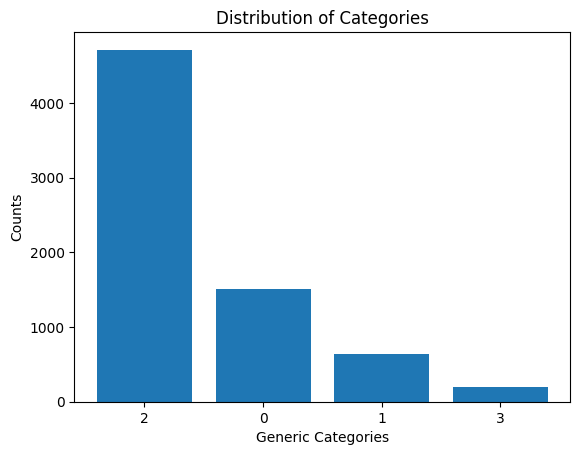

In [52]:
# Split data into input and output elements
X, y = df_known.iloc[:, :-1], df_known.iloc[:, -1]

# label encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

summarize_class_distribution(y)

In [53]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
def analyze_errors(model):
    # Define evaluation procedure
    cv = StratifiedKFold(n_splits=5, shuffle=True ,random_state=42)
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)
    conf_mx = confusion_matrix(y_train, y_train_pred)
    # Calculate error rates
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    # Fill diagonal with zeros to keep only the error rates
    np.fill_diagonal(norm_conf_mx, 0) 
    plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
    plt.show()

def evaluate_model(model):
    cv = StratifiedKFold(n_splits=5, shuffle=True ,random_state=42)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=cv)
    return scores

def test_model(model):
    # Fit the model in the training set
    model.fit(X_train, y_train) 
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    # Print classification report
    print(classification_report(y_test, y_pred))


##### Random Forest with cost-sensitive-learning

In [ ]:
rf_100 = RandomForestClassifier(n_estimators=100, class_weight='balanced' ,random_state=42)
rf_100_scores = evaluate_model(rf_100)
print(f"Mean F1 Score: {rf_100_scores.mean():.4f} (+/- {rf_100_scores.std():.4f})")

'\nrf_100 = RandomForestClassifier(n_estimators=100, class_weight=\'balanced\' ,random_state=42)\nrf_100_scores = evaluate_model(rf_100)\nprint(f"Mean F1 Score: {rf_100_scores.mean():.4f} (+/- {rf_100_scores.std():.4f})")\n'

In [ ]:
analyze_errors(rf_100)

In [ ]:
test_model(rf_100)

#### Conclusion: There are some stories with generic category 0 and 1 that are missclassified as 2. This is expected since generic category 2 dominates the class distribution. However, the model has a weighted average of 99% precision at 99% recall, which is a very good result.

In [58]:
def tune_rf_model():
    # Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['log2', 'sqrt'],
        'class_weight': ['balanced']
    }

    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier(random_state=42)

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=2, error_score='raise')

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Return the best model
    return grid_search.best_estimator_

In [ ]:
best_rf = tune_rf_model()
print(f"Best parameters: {best_rf.get_params()}")

'\nbest_rf = tune_rf_model()\nprint(f"Best parameters: {best_rf.get_params()}")\n'

In [ ]:
best_rf_scores = evaluate_model(best_rf)
print(f"Mean F1 Score: {best_rf_scores.mean():.4f} (+/- {best_rf_scores.std():.4f})")

'\nbest_rf_scores = evaluate_model(best_rf)\nprint(f"Mean F1 Score: {best_rf_scores.mean():.4f} (+/- {best_rf_scores.std():.4f})")\n'

In [ ]:
analyze_errors(best_rf)

'\nanalyze_errors(best_rf)\n'

In [ ]:
test_model(best_rf)

'\ntest_model(best_rf)\n'

In [63]:
def save_model(model, model_name, model_dir='../models/'):
    # Create the model directory if it doesn't exist
    os.makedirs(model_dir, exist_ok=True)
    # Save the model
    model_path = os.path.join(model_dir, f"{model_name}.pkl")
    joblib.dump(model, model_path)
    print(f"Model saved to {model_path}")

def load_model(model_name, model_dir='../models/'):
    # Load the model
    model_path = os.path.join(model_dir, f"{model_name}.pkl")
    model = joblib.load(model_path)
    print(f"Model loaded from {model_path}")
    return model

In [ ]:
save_model(best_rf, 'best_rf_model')
save_model(le, 'label_encoder')

"\nsave_model(best_rf, 'best_rf_model')\nsave_model(le, 'label_encoder')\n"

In [65]:
rf_model = load_model('best_rf_model')
label_encoder = load_model('label_encoder')

Model loaded from ../models/best_rf_model.pkl
Model loaded from ../models/label_encoder.pkl


In [66]:
# Samples with unknown generic category
X_unknown = df_unknown.iloc[:, :-1]

# Predict the generic category where missing
pred_encoded = rf_model.predict(X_unknown)

# Decode predictions back to original labels
pred_decoded = label_encoder.inverse_transform(pred_encoded)

# Assign predicted values to the missing rows
df_tfidf.loc[df_tfidf['generic_category_id'].isna(), 'generic_category_id'] = pred_decoded

# Copy predictions back to the original dataframe
df_story_categories['generic_category_id'] = df_tfidf['generic_category_id']

Class=2, n=15670 (79.25%)
Class=0, n=2851 (14.42%)
Class=3, n=214 (1.08%)
Class=1, n=1037 (5.24%)


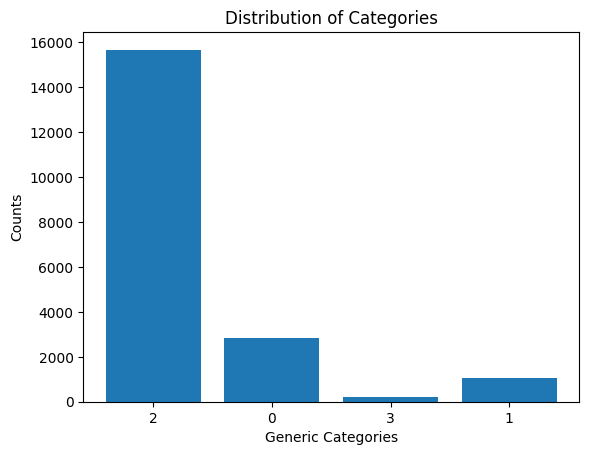

In [67]:
gen_cat = label_encoder.fit_transform(df_story_categories['generic_category_id'])

summarize_class_distribution(gen_cat)

In [68]:
df_story_categories.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19772 entries, 5 to 31291
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   tour_id              19772 non-null  Int64 
 1   story_title          19772 non-null  object
 2   generic_category_id  19772 non-null  Int64 
 3   basic_category_id    1761 non-null   Int64 
 4   difficulty_id        6541 non-null   Int64 
dtypes: Int64(4), object(1)
memory usage: 1023.4+ KB


In [69]:
# Reset index in df_story_categories
df_story_categories.reset_index(inplace=True)

# Drop unnecessary columns
df_story_categories.drop(columns=['tour_id', 'story_title'], inplace=True)

##### Load <code>Story_Theme_Categories.csv</code>

In [70]:
df_themes_cat = pd.read_csv('../data/Story_Theme_Categories.csv', sep=';', on_bad_lines='warn')
df_themes_cat.head()

,story_id,basic_category_id
0,11416,NaN
1,11416,1.0
2,11417,NaN
3,11417,3.0
4,11420,NaN


In [71]:
df_themes_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8505 entries, 0 to 8504
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   story_id           8505 non-null   int64  
 1   basic_category_id  5960 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 133.0 KB


In [72]:
# Convert data types
df_themes_cat['story_id'] = df_themes_cat['story_id'].astype('Int64')
df_themes_cat['basic_category_id'] = df_themes_cat['basic_category_id'].astype('Int64')

In [73]:
# Merge theme categories dataframe with tour_stories dataframe to check for stories not mapped to a tour_id
df_themes_cat = df_themes_cat.merge(df_tour_stories[['story_id','tour_id']], on='story_id', how='left')
df_themes_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8505 entries, 0 to 8504
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   story_id           8505 non-null   Int64
 1   basic_category_id  5960 non-null   Int64
 2   tour_id            8256 non-null   Int64
dtypes: Int64(3)
memory usage: 224.4 KB


In [74]:
# Drop theme stories not mapped to a tour_id
df_themes_cat.dropna(subset=['tour_id'], inplace=True)

# Drop tour_id column, since it is no longer needed
df_themes_cat.drop(columns=['tour_id'], inplace=True)
df_themes_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8256 entries, 0 to 8500
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   story_id           8256 non-null   Int64
 1   basic_category_id  5829 non-null   Int64
dtypes: Int64(2)
memory usage: 209.6 KB


In [75]:
# Check for duplicates
df_themes_cat.duplicated(subset=['story_id','basic_category_id']).any()

np.True_

In [76]:
# Remove duplicates based on story_id and basic_category_id
df_themes_cat.drop_duplicates(subset=['story_id','basic_category_id'], keep='first', inplace=True)
df_themes_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8142 entries, 0 to 8500
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   story_id           8142 non-null   Int64
 1   basic_category_id  5717 non-null   Int64
dtypes: Int64(2)
memory usage: 206.7 KB


In [77]:
th = df_story_categories[df_story_categories['generic_category_id'] == 2]['story_id'].unique().tolist()
print(f"Number of theme stories: {len(th)}")
print(f"Number of theme stories in themes category dataframe: {df_themes_cat['story_id'].nunique()}")

Number of theme stories: 15670
Number of theme stories in themes category dataframe: 4724


In [78]:
unique_themes = df_themes_cat['story_id'].unique()
df_story_categories[df_story_categories['story_id'].isin(unique_themes)]['generic_category_id'].unique()

<IntegerArray>
[2, 1]
Length: 2, dtype: Int64

##### Some stories included as themes in the themes category dataframe are marked as tips in the story categories dataframe. Let's check these stories more carefully

In [79]:
df_story_categories[(df_story_categories['story_id'].isin(unique_themes)) & (df_story_categories['generic_category_id'] == 1)]

,story_id,generic_category_id,basic_category_id,difficulty_id
7297,8786,1,3,1
7302,8791,1,3,1
13256,15045,1,3,<NA>
13259,15048,1,3,<NA>
13279,15068,1,<NA>,<NA>
15062,16992,1,<NA>,0
15479,17409,1,<NA>,<NA>
16250,20109,1,<NA>,<NA>
17729,23698,1,<NA>,<NA>
17821,23790,1,<NA>,<NA>


##### Based on <code>story_title</code> column, these stories are indeed tips. Therefore, they should be removed from the theme categories dataframe 

In [80]:
# Get the ids of the stories to be removed from df_themes_cat
stories_to_drop = df_story_categories[(df_story_categories['story_id'].isin(unique_themes)) & (df_story_categories['generic_category_id'] == 1)]['story_id'].unique()

# Drop the stories from df_themes_cat
df_themes_cat = df_themes_cat[~df_themes_cat['story_id'].isin(stories_to_drop)]
df_themes_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8127 entries, 0 to 8500
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   story_id           8127 non-null   Int64
 1   basic_category_id  5707 non-null   Int64
dtypes: Int64(2)
memory usage: 206.3 KB


In [81]:
print(f"Number of stories in themes category: {len(th)}")
print(f"Number of stories in themes category in df_themes_cat: {df_themes_cat['story_id'].nunique()}")

Number of stories in themes category: 15670
Number of stories in themes category in df_themes_cat: 4713


In [82]:
# Get all the ids of the stories in the themes category from df_story_categories
df_theme_ids = df_story_categories.loc[df_story_categories['generic_category_id'] == 2, 'story_id']

# Merge df_themes_cat with df_theme_ids to get the story ids in the themes category with their corresponding basic category
df_themes_cat = df_themes_cat.merge(df_theme_ids, on='story_id', how='right')
df_themes_cat.head()

,story_id,basic_category_id
0,5,<NA>
1,6,<NA>
2,7,<NA>
3,8,<NA>
4,9,<NA>


##### The majority of themes have missing values in basic_category_id. This is an important part of stories metadata that will be used in the recommendation system. Therefore, we will try to replace null values using the tour category that theme stories belong to, since tour categories and theme basic categories can be semantically similar.

##### Load <code>Tour_category.csv</code>

In [83]:
df_tour_cat = pd.read_csv('../data/Tour_category.csv', sep=';', on_bad_lines='warn')
df_tour_cat.head()

,id,tour_id,category_id
0,16,159,2
1,31,3,6
2,32,3,7
3,39,134,1
4,40,134,2


In [84]:
# Drop unnecessary columns
df_tour_cat.drop(columns=['id'], inplace=True)

# Rename category_id to tour_category_id
df_tour_cat.rename(columns={'category_id': 'tour_category_id'}, inplace=True)

In [85]:
df_tour_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357 entries, 0 to 1356
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   tour_id           1357 non-null   int64
 1   tour_category_id  1357 non-null   int64
dtypes: int64(2)
memory usage: 21.3 KB


In [86]:
# Covert data types
df_tour_cat['tour_id'] = df_tour_cat['tour_id'].astype('Int64')
df_tour_cat['tour_category_id'] = df_tour_cat['tour_category_id'].astype('Int64')

In [87]:
print(f"Number of unique tours in tour category dataframe: {df_tour_cat['tour_id'].nunique()}")
print(f"Actual number of unique tours: {df_tour_stories['tour_id'].nunique()}")

Number of unique tours in tour category dataframe: 552
Actual number of unique tours: 445


In [88]:
# Get unique tour ids from tour stories dataframe
df_tours = df_tour_stories.drop_duplicates(subset=['tour_id'], keep='first')

# Merge tour categories dataframe with tour stories dataframe to check for tours not assigned to a category
df_tour_cat = df_tour_cat.merge(df_tours[['tour_id']], on='tour_id', how='right')
df_tour_cat.head()

,tour_id,tour_category_id
0,1,7
1,1,15
2,3,6
3,3,7
4,5,2


In [89]:
# Check for duplicate values
df_tour_cat.duplicated(subset=['tour_id', 'tour_category_id']).any()

np.True_

In [90]:
# Drop duplicates
df_tour_cat.drop_duplicates(subset=['tour_id', 'tour_category_id'], keep='first', inplace=True)

In [91]:
df_tour_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1118 entries, 0 to 1120
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   tour_id           1118 non-null   Int64
 1   tour_category_id  1109 non-null   Int64
dtypes: Int64(2)
memory usage: 28.4 KB


##### Load <code>Category.csv</code>

In [92]:
df_tour_cat_names = pd.read_csv('../data/Category.csv', sep=';', on_bad_lines='warn')
df_tour_cat_names

,id,category_name
0,1,Literature
1,2,Performing arts
2,3,Gastronomy
3,4,Media arts
4,5,Virtual art
5,6,Architecture
6,7,History
7,8,Nature
8,9,Industrial
9,10,Adventure


In [93]:
df_tour_cat_names.rename(columns={'id': 'tour_category_id', 'category_name': 'tour_category_name'}, inplace=True)

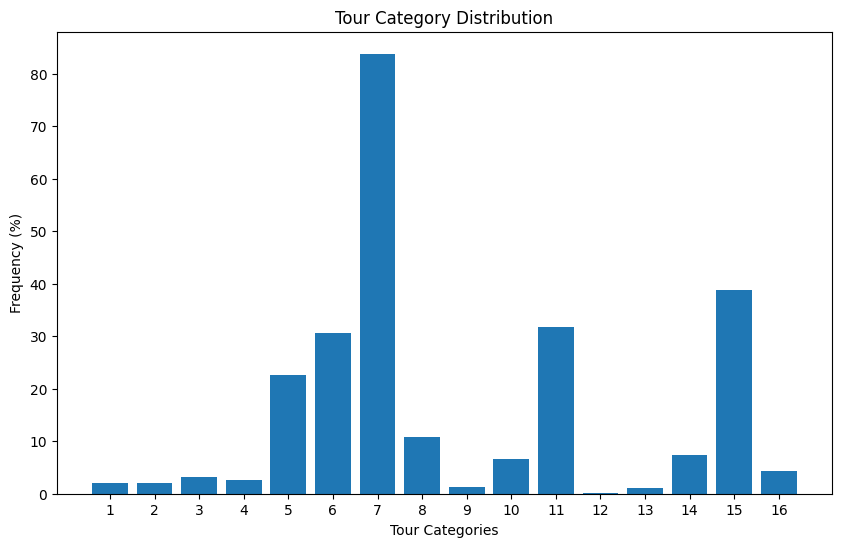

In [94]:
# Total number of unique tours 
total_tours_unique = df_tour_cat['tour_id'].nunique()

# Total number of tours per tour category
total_tours_per_cat = df_tour_cat.groupby('tour_category_id')['tour_id'].nunique()

# Calculate tour category frequency
tour_cat_freq = round((total_tours_per_cat / total_tours_unique) * 100, 2)

# Create barplot to display tour category distribution
plt.figure(figsize=(10,6))
plt.bar(tour_cat_freq.index.astype(str), tour_cat_freq.values)

# add labes and title
plt.xlabel('Tour Categories')
plt.ylabel('Frequency (%)')
plt.title('Tour Category Distribution')
plt.show()


##### Over 80% of tours have History as tour category. Therefore, we will fill tour_category_id missing values using the mode.

In [95]:
# Fill tour category id missing values 
df_tour_cat['tour_category_id'] = df_tour_cat['tour_category_id'].fillna(df_tour_cat['tour_category_id'].mode()[0])

In [96]:
df_tour_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1118 entries, 0 to 1120
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   tour_id           1118 non-null   Int64
 1   tour_category_id  1118 non-null   Int64
dtypes: Int64(2)
memory usage: 28.4 KB


##### Load <code>basic_categories.csv</code>

In [97]:
df_basic_cat = pd.read_csv('../data/basic_categories.csv', on_bad_lines='warn')
df_basic_cat

,id,generic_category_id,basic_category
0,0,0,Directions
1,1,0,Introduction
2,2,0,Closure
3,0,1,Shopping
4,1,1,Gastronomy-Restaurant
5,2,1,Nightlife-Bar
6,3,1,Alternative activity
7,4,1,Selfie stop
8,0,2,History
9,1,2,Architecture


In [98]:
df_basic_cat.rename(columns={'id': 'basic_category_id', 'basic_category': 'basic_category_name'}, inplace=True)

#### Assignment of theme basic categories using tour categories

In [99]:
# Merge with tour stories dataframe to map stories to tour_id
df_themes_cat = df_themes_cat.merge(df_tour_stories[['story_id', 'tour_id']], on='story_id')

# Merge with tour categories dataframe to map tours to tour_category_id
df_themes_cat = df_themes_cat.merge(df_tour_cat, on='tour_id')

In [100]:
df_themes_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49445 entries, 0 to 49444
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   story_id           49445 non-null  Int64
 1   basic_category_id  15736 non-null  Int64
 2   tour_id            49445 non-null  Int64
 3   tour_category_id   49445 non-null  Int64
dtypes: Int64(4)
memory usage: 1.7 MB


In [101]:
# Create copy of themes category dataframe
df_themes_cat_copy = df_themes_cat.copy()

# Drop records with missing basic_category_id
df_themes_cat_copy.dropna(subset=['basic_category_id'], inplace=True)

# Create generic_category_id for themes category to merge with basic categories dataframe
df_themes_cat_copy['generic_category_id'] = 2  

# Merge with basic categories dataframe to map basic_category_id to basic category name
df_themes_cat_copy = df_themes_cat_copy.merge(df_basic_cat, on=['generic_category_id', 'basic_category_id'])

# Merge with tour category names dataframe to map tour_category_id to tour category name
df_themes_cat_copy = df_themes_cat_copy.merge(df_tour_cat_names, on='tour_category_id')

df_themes_cat_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15736 entries, 0 to 15735
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   story_id             15736 non-null  Int64 
 1   basic_category_id    15736 non-null  Int64 
 2   tour_id              15736 non-null  Int64 
 3   tour_category_id     15736 non-null  Int64 
 4   generic_category_id  15736 non-null  int64 
 5   basic_category_name  15736 non-null  object
 6   tour_category_name   15736 non-null  object
dtypes: Int64(4), int64(1), object(2)
memory usage: 922.2+ KB


##### We will perform Chi-Squared test to check the relationship between categorical variables <code>tour_category_name</code> and <code>basic_category_name.</code> If the variables are associated, we can use the most frequent <code>basic_category_id</code> within each <code>tour_category_id</code> group to fill the missing values in <code>basic_category_id</code> 

In [102]:
# Create contigency table
contingency_table = pd.crosstab(df_themes_cat_copy['basic_category_name'], df_themes_cat_copy['tour_category_name'], margins=True, margins_name="Total")
contingency_table

tour_category_name,Adventure,Architecture,Family,Gallery,History,Industrial,Literature,Museum,Nature,Virtual art,Walking,Total
basic_category_name,,,,,,,,,,,,
Archeology,39,482,57,0,826,0,0,536,15,0,384,2339
Architecture,49,1398,79,20,1785,35,21,350,296,17,1038,5088
Art,38,1093,73,76,1615,32,6,625,179,30,703,4470
Fun,5,55,15,0,99,0,0,41,19,1,67,302
Kids,0,0,0,0,3,0,0,0,3,0,1,7
Mythology,20,114,32,0,232,0,0,100,21,1,121,641
Nature,11,107,11,0,187,0,2,33,116,0,121,588
Quirky,12,120,20,2,199,1,8,74,26,0,131,593
Religion,19,539,9,28,622,3,0,141,59,27,182,1629


#### The standard chi-squared test assumes that expected frequencies are at least 5 in all cells. In our case, the contingency table between tour_category and basic_category is sparse, violating this assumption. We will use the Monte Carlo chi-squared test to simulate the null distribution and compute a more reliable p-value, making the test suitable for sparse categorical data.

In [103]:
def monte_carlo_chi_squared_test(data, row_var, col_var, num_simulations=10000):
    np.random.seed(42)  # For reproducibility

    # Create observed contigency table
    observed = pd.crosstab(data[row_var], data[col_var])
    row_totals = observed.sum(axis=1).values
    col_totals = observed.sum(axis=0).values
    grand_total = observed.values.sum()

    # Compute the chi-squared statistic for the observed data
    observed_stat, _, _, _ = chi2_contingency(observed, correction=False)

    # Simulate tables under the null hypothesis
    simulated_stats = []
    for _ in range(num_simulations):
        # Generate a simulated table by sampling from the expected multinomial distribution
        simulated_table = np.array([np.random.multinomial(row_sum, col_totals / grand_total) 
                                    for row_sum in row_totals])
        
        # Compute the chi-squared statistic for the simulated table
        stat, _, _, _ = chi2_contingency(simulated_table, correction=False)
        simulated_stats.append(stat)
    
    # Estimate p-value
    simulated_stats = np.array(simulated_stats)
    p_value = np.mean(simulated_stats >= observed_stat)

    return observed_stat, p_value

In [104]:
stat, p_value = monte_carlo_chi_squared_test(df_themes_cat_copy, 'basic_category_name', 'tour_category_name')
print(f"Observed Chi-squared statistic: {stat:.2f}, Monte Carlo p-value: {p_value:.10f}")

Observed Chi-squared statistic: 1400.19, Monte Carlo p-value: 0.0000000000


##### Since <code>p-value < 0.05</code>, we reject the null hypothesis. Thus, categorical variables tour_category and theme_basic_category are not independent.

In [105]:
# Calculate the mode of basic_category_id for each tour_category_id
tour_basic_cat_mode = (
    df_themes_cat_copy.groupby('tour_category_id')['basic_category_id']
    .agg(lambda x: x.mode()[0])
    .reset_index()
    .rename(columns={'basic_category_id': 'basic_category_id_mode'})
)

# Merge the mode values back to the original theme categories dataframe
df_themes_cat = df_themes_cat.merge(tour_basic_cat_mode, on='tour_category_id', how='left')

# Fill missing basic_category_id values with the mode
df_themes_cat['basic_category_id'] = df_themes_cat['basic_category_id'].fillna(df_themes_cat['basic_category_id_mode'])

df_themes_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49445 entries, 0 to 49444
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   story_id                49445 non-null  Int64
 1   basic_category_id       48234 non-null  Int64
 2   tour_id                 49445 non-null  Int64
 3   tour_category_id        49445 non-null  Int64
 4   basic_category_id_mode  48234 non-null  Int64
dtypes: Int64(5)
memory usage: 2.1 MB


In [106]:
df_themes_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49445 entries, 0 to 49444
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   story_id                49445 non-null  Int64
 1   basic_category_id       48234 non-null  Int64
 2   tour_id                 49445 non-null  Int64
 3   tour_category_id        49445 non-null  Int64
 4   basic_category_id_mode  48234 non-null  Int64
dtypes: Int64(5)
memory usage: 2.1 MB


In [107]:
# Check for duplicates in the themes category dataframe
df_themes_cat.duplicated(subset=['story_id','tour_category_id', 'basic_category_id']).any()

np.True_

In [108]:
# Check tour categories where basic_category_id is still missing
df_themes_cat[df_themes_cat['basic_category_id_mode'].isna()]['tour_category_id'].unique()

<IntegerArray>
[2, 4, 3, 13, 12]
Length: 5, dtype: Int64

##### There are still null values in basic_category_id field. This is because for some tour categories there was not available data about their corresponding basic categories to fill null values with their most frequent basic category. In such cases, we will replace missing values using the mode of basic_category_id. 

In [109]:
# Replace basic_category_id null values with the mode of basic_category_id
df_themes_cat['basic_category_id'] = df_themes_cat['basic_category_id'].fillna(df_themes_cat['basic_category_id'].mode()[0])

# Drop columns in themes category dataframe that are no longer needed
df_themes_cat.drop(columns=['tour_id','tour_category_id','basic_category_id_mode'], inplace=True)

df_themes_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49445 entries, 0 to 49444
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   story_id           49445 non-null  Int64
 1   basic_category_id  49445 non-null  Int64
dtypes: Int64(2)
memory usage: 869.3 KB


##### Load android users interaction data

In [110]:
pd.read_csv('../data/android_track_listened.csv', on_bad_lines = 'warn')

C:\Users\Βασίλης\AppData\Local\Temp\ipykernel_17252\2606961994.py:1: ParserWarning:

Skipping line 6: expected 41 fields, saw 42
Skipping line 31: expected 41 fields, saw 42
Skipping line 35: expected 41 fields, saw 42
Skipping line 108: expected 41 fields, saw 42
Skipping line 127: expected 41 fields, saw 42
Skipping line 186: expected 41 fields, saw 43
Skipping line 200: expected 41 fields, saw 42
Skipping line 205: expected 41 fields, saw 42
Skipping line 207: expected 41 fields, saw 42
Skipping line 306: expected 41 fields, saw 43
Skipping line 318: expected 41 fields, saw 42
Skipping line 379: expected 41 fields, saw 42
Skipping line 403: expected 41 fields, saw 42
Skipping line 417: expected 41 fields, saw 42
Skipping line 445: expected 41 fields, saw 42
Skipping line 454: expected 41 fields, saw 43
Skipping line 494: expected 41 fields, saw 43
Skipping line 511: expected 41 fields, saw 43
Skipping line 603: expected 41 fields, saw 42
Skipping line 626: expected 41 fields, saw 42

,id,received_at,context_device_manufacturer,context_device_name,context_network_cellular,context_user_agent,event_text,original_timestamp,story_id,context_app_build,...,context_device_type,context_locale,context_network_carrier,anonymous_id,event,context_timezone,context_device_ad_tracking_enabled,context_device_advertising_id,user_id,context_traits_user_id
0,afbcd9ba-16a5-4bb2-8062-a932239b25b7,2022-05-01 04:44:16.578+00,samsung,a52sxq,False,Dalvik/2.1.0 (Linux; U; Android 12; SM-A528B B...,Track Listened,2022-04-30 10:47:37.766+00,9639.0,5060001.0,...,android,nl-NL,COSMOTE,fdd1cd0e-92ad-48a5-a26e-44341763932b,track_listened,Europe/Athens,False,NaN,NaN,NaN
1,70253e0c-6ab2-4ebd-ad6e-9594d77596d7,2022-05-03 09:20:34.617+00,HUAWEI,HWLYA,True,Dalvik/2.1.0 (Linux; U; Android 10; LYA-L29 Bu...,Track Listened,2022-05-03 09:20:07.807+00,6715.0,5060001.0,...,android,de-DE,COSMOTE,32b6a731-a8c2-418f-a16e-2f54684eba9d,track_listened,Europe/Athens,False,NaN,73348.0,73348.0
2,9a0cee15-713e-4a88-a9c0-5ec86f823523,2022-05-03 09:26:34.678+00,HUAWEI,HWLYA,True,Dalvik/2.1.0 (Linux; U; Android 10; LYA-L29 Bu...,Track Listened,2022-05-03 09:26:14.386+00,6721.0,5060001.0,...,android,de-DE,COSMOTE,32b6a731-a8c2-418f-a16e-2f54684eba9d,track_listened,Europe/Athens,False,NaN,73348.0,73348.0
3,086742a8-4dbe-4b2a-aaf9-0e781cbc6ba9,2022-05-01 04:44:16.578+00,samsung,a52sxq,False,Dalvik/2.1.0 (Linux; U; Android 12; SM-A528B B...,Track Listened,2022-04-30 09:53:36.975+00,5344.0,5060001.0,...,android,nl-NL,COSMOTE,fdd1cd0e-92ad-48a5-a26e-44341763932b,track_listened,Europe/Athens,False,NaN,NaN,NaN
4,39e018eb-d849-4c88-9394-cec1aeeababf,2022-05-01 04:44:16.578+00,samsung,a52sxq,False,Dalvik/2.1.0 (Linux; U; Android 12; SM-A528B B...,Track Listened,2022-04-30 09:52:18.419+00,5343.0,5060001.0,...,android,nl-NL,COSMOTE,fdd1cd0e-92ad-48a5-a26e-44341763932b,track_listened,Europe/Athens,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191787,8f7909c3-8774-4b9f-ab0a-410949f6f5f2,2022-09-28 07:08:01.229+00,HUAWEI,HWWAS-H,False,Dalvik/2.1.0 (Linux; U; Android 8.0.0; WAS-LX1...,Track Listened,2022-09-28 07:07:44.403+00,9637.0,5100050.0,...,android,de-AT,COSMOTE,3953a42c-b954-4529-b6f3-a880e60e1858,track_listened,Europe/Athens,True,aea11e9f-4ac7-4f01-96fd-adb59d784f9f,132380.0,132380.0
191788,8f7d919f-79ee-4535-a8d0-c32f19fd2242,2022-09-28 14:27:51.449+00,Google,redfin,False,Dalvik/2.1.0 (Linux; U; Android 13; Pixel 5 Bu...,Track Listened,2022-09-28 14:27:52.065+00,7729.0,5100050.0,...,android,en-US,vodafone IT,a76c2842-0eea-43f4-9bfb-1826a80b7565,track_listened,Europe/Rome,True,999fe064-421b-4622-99bd-8cb4e0c2e37e,130988.0,130988.0
191789,8f7e16e8-1de6-4cc5-a497-1d5c72059b65,2022-09-28 10:48:59.357+00,samsung,o1s,True,Dalvik/2.1.0 (Linux; U; Android 12; SM-G991B B...,Track Listened,2022-09-28 10:48:53.935+00,9841.0,5100050.0,...,android,de-DE,vodafone GR,98ccd99b-a438-4b1e-8e76-a60363c7fa24,track_listened,Europe/Athens,True,79fcd789-c1d6-417c-bbdc-56f6ad9e2403,132491.0,132491.0
191790,8f7f190e-2fd9-42c5-8c0d-5cd4b75f4ad3,2022-09-28 10:28:49.341+00,HUAWEI,HWSNE,False,Dalvik/2.1.0 (Linux; U; Android 10; SNE-LX1 Bu...,Track Listened,2022-09-28 10:28:39.888+00,6745.0,5100050.0,...,android,fr-FR,COSMOTE,7f61e799-a4cd-4fd8-a0b6-b76747e618d8,track_listened,Europe/Athens,True,654d51d3-ad61-468a-be88-7bd7c27469f2,NaN,NaN


##### Investigate bad lines

In [111]:
with open('../data/android_track_listened.csv', 'r', encoding='utf-8') as f:
    data = f.readlines()
bad_lines = [30, 34, 107, 73377]
for line_idx in bad_lines:
    print(data[line_idx])

f19c76bf-6601-4bb6-8c91-0eb27d2af985,2022-05-01 04:44:16.578+00,samsung,a52sxq,False,Dalvik/2.1.0 (Linux; U; Android 12; SM-A528B Build/SP1A.210812.016),Track Listened,2022-04-30 09:31:24.289+00,5350,5060001,1080,4.10.0,SM-A528B,12,3.375,2150,35,Enter a hero, emerge a god,2022-04-30 09:31:22.782+00,com.cliomuseapp.cliomuseapp,2022-05-01 07:13:08+00,16e8cf892b4c3f37,analytics-android,True,Android,Clio Muse Tours,37.6.173.251,False,fdd1cd0e-92ad-48a5-a26e-44341763932b,2022-05-01 04:44:16+00,5.0.6,android,nl-NL,COSMOTE,fdd1cd0e-92ad-48a5-a26e-44341763932b,track_listened,Europe/Athens,False,NULL,NULL,NULL

ff14d9ac-ef48-4cc9-b5bb-eb7f5a3065f0,2022-05-01 04:44:16.578+00,samsung,a52sxq,False,Dalvik/2.1.0 (Linux; U; Android 12; SM-A528B Build/SP1A.210812.016),Track Listened,2022-04-30 09:32:22.87+00,5350,5060001,1080,4.10.0,SM-A528B,12,3.375,2150,42,Enter a hero, emerge a god,2022-04-30 09:32:21.363+00,com.cliomuseapp.cliomuseapp,2022-05-01 07:13:08+00,16e8cf892b4c3f37,analytics-android,True,

In [112]:
clean_lines_android = []

with open('../data/android_track_listened.csv', 'r', encoding='utf-8') as f:
    for line in f:
        line = re.sub(r'([a-zA-Z])\, ', r'\1 ', line)
        line = re.sub(r'250,000', '250000 ', line)
        line = re.sub(r',,', ',', line)
        line = re.sub(r'Μαρμάρινο αγγείο,', 'Μαρμάρινο αγγείο ', line)
        line = re.sub(r'24h/24,', '24h/24 ', line)
        clean_lines_android.append(line)

# Convert the cleaned lines into a single string
clean_data_android = io.StringIO(''.join(clean_lines_android))

df_android = pd.read_csv(clean_data_android, on_bad_lines='warn')

C:\Users\Βασίλης\AppData\Local\Temp\ipykernel_17252\495109958.py:15: DtypeWarning:

Columns (23,27,37) have mixed types. Specify dtype option on import or set low_memory=False.



In [113]:
df_android.head()

,id,received_at,context_device_manufacturer,context_device_name,context_network_cellular,context_user_agent,event_text,original_timestamp,story_id,context_app_build,...,context_device_type,context_locale,context_network_carrier,anonymous_id,event,context_timezone,context_device_ad_tracking_enabled,context_device_advertising_id,user_id,context_traits_user_id
0,afbcd9ba-16a5-4bb2-8062-a932239b25b7,2022-05-01 04:44:16.578+00,samsung,a52sxq,False,Dalvik/2.1.0 (Linux; U; Android 12; SM-A528B B...,Track Listened,2022-04-30 10:47:37.766+00,9639.0,5060001.0,...,android,nl-NL,COSMOTE,fdd1cd0e-92ad-48a5-a26e-44341763932b,track_listened,Europe/Athens,False,NaN,NaN,NaN
1,70253e0c-6ab2-4ebd-ad6e-9594d77596d7,2022-05-03 09:20:34.617+00,HUAWEI,HWLYA,True,Dalvik/2.1.0 (Linux; U; Android 10; LYA-L29 Bu...,Track Listened,2022-05-03 09:20:07.807+00,6715.0,5060001.0,...,android,de-DE,COSMOTE,32b6a731-a8c2-418f-a16e-2f54684eba9d,track_listened,Europe/Athens,False,NaN,73348.0,73348.0
2,9a0cee15-713e-4a88-a9c0-5ec86f823523,2022-05-03 09:26:34.678+00,HUAWEI,HWLYA,True,Dalvik/2.1.0 (Linux; U; Android 10; LYA-L29 Bu...,Track Listened,2022-05-03 09:26:14.386+00,6721.0,5060001.0,...,android,de-DE,COSMOTE,32b6a731-a8c2-418f-a16e-2f54684eba9d,track_listened,Europe/Athens,False,NaN,73348.0,73348.0
3,086742a8-4dbe-4b2a-aaf9-0e781cbc6ba9,2022-05-01 04:44:16.578+00,samsung,a52sxq,False,Dalvik/2.1.0 (Linux; U; Android 12; SM-A528B B...,Track Listened,2022-04-30 09:53:36.975+00,5344.0,5060001.0,...,android,nl-NL,COSMOTE,fdd1cd0e-92ad-48a5-a26e-44341763932b,track_listened,Europe/Athens,False,NaN,NaN,NaN
4,18fe4b72-b2be-4ab7-886d-0426f479835f,2022-05-01 04:44:16.578+00,samsung,a52sxq,False,Dalvik/2.1.0 (Linux; U; Android 12; SM-A528B B...,Track Listened,2022-04-30 09:31:31.838+00,5350.0,5060001.0,...,android,nl-NL,COSMOTE,fdd1cd0e-92ad-48a5-a26e-44341763932b,track_listened,Europe/Athens,False,NaN,NaN,NaN


In [114]:
df_android.shape

(194071, 41)

In [115]:
df_android.columns

Index(['id', 'received_at', 'context_device_manufacturer',
       'context_device_name', 'context_network_cellular', 'context_user_agent',
       'event_text', 'original_timestamp', 'story_id', 'context_app_build',
       'context_screen_width', 'context_library_version',
       'context_device_model', 'context_os_version', 'context_screen_density',
       'context_screen_height', 'duration', 'story_title', 'timestamp',
       'context_app_namespace', 'uuid_ts', 'context_device_id',
       'context_library_name', 'context_network_wifi', 'context_os_name',
       'context_app_name', 'context_ip', 'context_network_bluetooth',
       'context_traits_anonymous_id', 'sent_at', 'context_app_version',
       'context_device_type', 'context_locale', 'context_network_carrier',
       'anonymous_id', 'event', 'context_timezone',
       'context_device_ad_tracking_enabled', 'context_device_advertising_id',
       'user_id', 'context_traits_user_id'],
      dtype='object')

In [116]:
df_android.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194071 entries, 0 to 194070
Data columns (total 41 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  194000 non-null  object 
 1   received_at                         194071 non-null  object 
 2   context_device_manufacturer         194071 non-null  object 
 3   context_device_name                 194071 non-null  object 
 4   context_network_cellular            194071 non-null  bool   
 5   context_user_agent                  194065 non-null  object 
 6   event_text                          194071 non-null  object 
 7   original_timestamp                  194071 non-null  object 
 8   story_id                            194000 non-null  float64
 9   context_app_build                   194000 non-null  float64
 10  context_screen_width                194000 non-null  float64
 11  context_library_version   

##### We will keep the following attributes:
 - <code>event_text</code>: description of the event
 - <code>story_id</code>: the id of the story the user interacted with
 - <code>story_title</code>: the title of the story the user interacted with
 - <code>duration</code>: time the user spent listenting the track of the story
 - <code>context_device_type</code>: the type of uder's device (Android/ios)
 - <code>anonymous_id</code>: id that is assigned to a user who has not created an account
 - <code>user_id</code>: id that is assigned to a user who has created an account
 - <code>original_timestamp</code>: the timestamp that the event originally took place
 - <code>context_locale</code>: language and regional settings configured on the user’s device
 - <code>context_device_name</code>: a short identifier of the user's device(e.g. sofiap)  

In [117]:
df_android['event_text'].unique()

array(['Track Listened', '73603', '80845', '85045', '89721', '92219',
       '96980', '97276', '99162', '99581', '98944', '99178', '99523',
       '99631', '114741'], dtype=object)

In [118]:
df_android[df_android['event_text'] != 'Track Listened']

,id,received_at,context_device_manufacturer,context_device_name,context_network_cellular,context_user_agent,event_text,original_timestamp,story_id,context_app_build,...,context_device_type,context_locale,context_network_carrier,anonymous_id,event,context_timezone,context_device_ad_tracking_enabled,context_device_advertising_id,user_id,context_traits_user_id
3555,NaN,fc8b2b71-49b1-450a-9bba-2ce0d9733ac6,track_listened,Europe/Athens,True,052bdbe1-c404-4934-bd90-45ad67720082,73603,73603,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3865,NaN,fc8b2b71-49b1-450a-9bba-2ce0d9733ac6,track_listened,Europe/Athens,True,052bdbe1-c404-4934-bd90-45ad67720082,73603,73603,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4018,NaN,fc8b2b71-49b1-450a-9bba-2ce0d9733ac6,track_listened,Europe/Athens,True,052bdbe1-c404-4934-bd90-45ad67720082,73603,73603,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4885,NaN,fc8b2b71-49b1-450a-9bba-2ce0d9733ac6,track_listened,Europe/Athens,True,052bdbe1-c404-4934-bd90-45ad67720082,73603,73603,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5475,NaN,fc8b2b71-49b1-450a-9bba-2ce0d9733ac6,track_listened,Europe/Athens,True,052bdbe1-c404-4934-bd90-45ad67720082,73603,73603,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134332,NaN,60c0212f-fa4f-43b0-af7b-464f5ee54ee3,track_listened,Europe/Athens,True,7a486ca2-c623-46b9-8b5e-5923a029102c,114741,114741,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134339,NaN,60c0212f-fa4f-43b0-af7b-464f5ee54ee3,track_listened,Europe/Athens,True,7a486ca2-c623-46b9-8b5e-5923a029102c,114741,114741,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134357,NaN,60c0212f-fa4f-43b0-af7b-464f5ee54ee3,track_listened,Europe/Athens,True,7a486ca2-c623-46b9-8b5e-5923a029102c,114741,114741,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134821,NaN,60c0212f-fa4f-43b0-af7b-464f5ee54ee3,track_listened,Europe/Athens,True,7a486ca2-c623-46b9-8b5e-5923a029102c,114741,114741,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
df_android.drop(df_android[df_android['event_text'] != "Track Listened"].index, inplace=True)
df_android.shape

(194000, 41)

In [120]:
df_android.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194000 entries, 0 to 194070
Data columns (total 41 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  194000 non-null  object 
 1   received_at                         194000 non-null  object 
 2   context_device_manufacturer         194000 non-null  object 
 3   context_device_name                 194000 non-null  object 
 4   context_network_cellular            194000 non-null  bool   
 5   context_user_agent                  194000 non-null  object 
 6   event_text                          194000 non-null  object 
 7   original_timestamp                  194000 non-null  object 
 8   story_id                            194000 non-null  float64
 9   context_app_build                   194000 non-null  float64
 10  context_screen_width                194000 non-null  float64
 11  context_library_version        

In [121]:
df_android.columns

Index(['id', 'received_at', 'context_device_manufacturer',
       'context_device_name', 'context_network_cellular', 'context_user_agent',
       'event_text', 'original_timestamp', 'story_id', 'context_app_build',
       'context_screen_width', 'context_library_version',
       'context_device_model', 'context_os_version', 'context_screen_density',
       'context_screen_height', 'duration', 'story_title', 'timestamp',
       'context_app_namespace', 'uuid_ts', 'context_device_id',
       'context_library_name', 'context_network_wifi', 'context_os_name',
       'context_app_name', 'context_ip', 'context_network_bluetooth',
       'context_traits_anonymous_id', 'sent_at', 'context_app_version',
       'context_device_type', 'context_locale', 'context_network_carrier',
       'anonymous_id', 'event', 'context_timezone',
       'context_device_ad_tracking_enabled', 'context_device_advertising_id',
       'user_id', 'context_traits_user_id'],
      dtype='object')

In [122]:
# Drop unecessary columns
cols_drop_android = ['id', 'received_at', 'context_device_manufacturer', 'context_network_cellular', 'context_user_agent',
        'context_app_build', 'context_screen_width', 'context_library_version', 'context_device_model' ,
        'context_os_version', 'context_screen_density', 'context_screen_height', 'timestamp',  'context_app_namespace', 'uuid_ts', 'context_device_id',
        'context_library_name', 'context_network_wifi', 'context_os_name' ,'context_app_name', 'context_ip', 'context_network_bluetooth',
        'context_traits_anonymous_id', 'sent_at', 'context_app_version', 'context_network_carrier', 'event', 'context_timezone',
        'context_device_ad_tracking_enabled', 'context_device_advertising_id', 'context_traits_user_id'] 

df_android.drop(columns=cols_drop_android, inplace=True)

In [123]:
df_android.columns

Index(['context_device_name', 'event_text', 'original_timestamp', 'story_id',
       'duration', 'story_title', 'context_device_type', 'context_locale',
       'anonymous_id', 'user_id'],
      dtype='object')

In [124]:
# Convert data types
df_android['story_id'] = df_android['story_id'].astype('Int64')
df_android['user_id'] = df_android['user_id'].astype('object')
df_android['anonymous_id'] = df_android['anonymous_id'].astype('object')

In [125]:
df_android['context_device_type'].unique()

array(['android'], dtype=object)

In [126]:
df_android = df_android.merge(df_tour_stories[['story_id', 'tour_id']], on='story_id', how='left')
df_android.head()

,context_device_name,event_text,original_timestamp,story_id,duration,story_title,context_device_type,context_locale,anonymous_id,user_id,tour_id
0,a52sxq,Track Listened,2022-04-30 10:47:37.766+00,9639,61.0,Back to Life,android,nl-NL,fdd1cd0e-92ad-48a5-a26e-44341763932b,NaN,51
1,HWLYA,Track Listened,2022-05-03 09:20:07.807+00,6715,68.0,Die Treppe,android,de-DE,32b6a731-a8c2-418f-a16e-2f54684eba9d,73348.0,240
2,HWLYA,Track Listened,2022-05-03 09:26:14.386+00,6721,54.0,Die Galerie,android,de-DE,32b6a731-a8c2-418f-a16e-2f54684eba9d,73348.0,240
3,a52sxq,Track Listened,2022-04-30 09:53:36.975+00,5344,55.0,Apollo and the dolphins,android,nl-NL,fdd1cd0e-92ad-48a5-a26e-44341763932b,NaN,181
4,a52sxq,Track Listened,2022-04-30 09:31:31.838+00,5350,1.0,Enter a hero emerge a god,android,nl-NL,fdd1cd0e-92ad-48a5-a26e-44341763932b,NaN,181


In [127]:
df_android.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194000 entries, 0 to 193999
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   context_device_name  194000 non-null  object 
 1   event_text           194000 non-null  object 
 2   original_timestamp   194000 non-null  object 
 3   story_id             194000 non-null  Int64  
 4   duration             194000 non-null  float64
 5   story_title          194000 non-null  object 
 6   context_device_type  194000 non-null  object 
 7   context_locale       194000 non-null  object 
 8   anonymous_id         193929 non-null  object 
 9   user_id              181366 non-null  object 
 10  tour_id              193623 non-null  Int64  
dtypes: Int64(2), float64(1), object(8)
memory usage: 16.7+ MB


##### Some records in <code>df_android</code> have story_ids that are not mapped to a tour_id. 

In [128]:
df_android['tour_id'].isna().any()

np.True_

In [129]:
# Remove rows with missing tour_id
df_android = df_android.dropna(subset=['tour_id'])
df_android.shape

(193623, 11)

In [130]:
# Drop tour_id column, since it is no longer needed
df_android.drop(columns=['tour_id'], inplace=True)

##### We only need one feature indicating user_id. We will keep <code>anonymous_id</code>, which is autogenerated each type a user uses the app.

In [131]:
df_android.drop(columns=['user_id'], inplace=True)

In [132]:
df_android[df_android['anonymous_id'].isna()]

,context_device_name,event_text,original_timestamp,story_id,duration,story_title,context_device_type,context_locale,anonymous_id
3554,sweet,Track Listened,2022-05-03 07:17:51.27+00,12760,25.0,Ένα αλλοτινό καμπαναριό,android,el-GR,NaN
3863,sweet,Track Listened,2022-05-03 07:15:56.545+00,4087,22.0,Ένα μνημείο-σύμβολο,android,el-GR,NaN
4015,sweet,Track Listened,2022-05-03 07:16:58.376+00,3160,35.0,Το κέντρο του κόσμου,android,el-GR,NaN
4881,sweet,Track Listened,2022-05-03 07:16:22.668+00,3291,26.0,Προσφέροντας την κάθαρση,android,el-GR,NaN
5470,sweet,Track Listened,2022-05-03 07:17:25.287+00,3156,26.0,Το μαντείο του θεού του φωτός,android,el-GR,NaN
...,...,...,...,...,...,...,...,...,...
134265,lavender,Track Listened,2022-08-14 08:35:59.989+00,12515,65.0,A Great Visionary,android,el-GR,NaN
134271,lavender,Track Listened,2022-08-14 08:37:09.24+00,12516,65.0,A turning point,android,el-GR,NaN
134288,lavender,Track Listened,2022-08-14 08:37:30.375+00,12517,21.0,Directions,android,el-GR,NaN
134751,lavender,Track Listened,2022-08-14 08:44:01.049+00,12526,66.0,The First Palaces,android,el-GR,NaN


In [133]:
# Assign row ids where anonymous_id is null to a list
anonymous_ids_null = df_android[df_android['anonymous_id'].isna()].index.to_list()

##### We assume that each device name indicates a distinct user. Therefore, we group records by <code>context_device_name</code> and replace <code>anonymous_id</code> null values with a unique id for each device name.

In [134]:
def generate_uuid():
    return str(uuid.uuid4())

# Identify records where anonymous_id is null
mask = df_android['anonymous_id'].isna()

# Extract unique context_device_name values where anonymous_id is null
ids_to_fill = df_android.loc[mask.index, 'context_device_name'].unique()

# Generate a unique ID for each context_device_name in this subset
uuid_mapping = {context_device_name:generate_uuid() for context_device_name in ids_to_fill}

# Assign the generated UUIDs to matching context_device_name rows where anonymous_id is null
df_android.loc[mask.index, 'anonymous_id'] = df_android.loc[mask.index,'context_device_name'].map(uuid_mapping)

In [135]:
df_android.loc[anonymous_ids_null]

,context_device_name,event_text,original_timestamp,story_id,duration,story_title,context_device_type,context_locale,anonymous_id
3554,sweet,Track Listened,2022-05-03 07:17:51.27+00,12760,25.0,Ένα αλλοτινό καμπαναριό,android,el-GR,6604eb20-c79f-41af-bc15-779205538e25
3863,sweet,Track Listened,2022-05-03 07:15:56.545+00,4087,22.0,Ένα μνημείο-σύμβολο,android,el-GR,6604eb20-c79f-41af-bc15-779205538e25
4015,sweet,Track Listened,2022-05-03 07:16:58.376+00,3160,35.0,Το κέντρο του κόσμου,android,el-GR,6604eb20-c79f-41af-bc15-779205538e25
4881,sweet,Track Listened,2022-05-03 07:16:22.668+00,3291,26.0,Προσφέροντας την κάθαρση,android,el-GR,6604eb20-c79f-41af-bc15-779205538e25
5470,sweet,Track Listened,2022-05-03 07:17:25.287+00,3156,26.0,Το μαντείο του θεού του φωτός,android,el-GR,6604eb20-c79f-41af-bc15-779205538e25
...,...,...,...,...,...,...,...,...,...
134265,lavender,Track Listened,2022-08-14 08:35:59.989+00,12515,65.0,A Great Visionary,android,el-GR,16e8398b-7789-4601-88bf-973804eafad9
134271,lavender,Track Listened,2022-08-14 08:37:09.24+00,12516,65.0,A turning point,android,el-GR,16e8398b-7789-4601-88bf-973804eafad9
134288,lavender,Track Listened,2022-08-14 08:37:30.375+00,12517,21.0,Directions,android,el-GR,16e8398b-7789-4601-88bf-973804eafad9
134751,lavender,Track Listened,2022-08-14 08:44:01.049+00,12526,66.0,The First Palaces,android,el-GR,16e8398b-7789-4601-88bf-973804eafad9


In [136]:
# Drop context device name, since it is no longer needed
df_android.drop(columns=['context_device_name'], inplace=True)

In [137]:
df_android.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193623 entries, 0 to 193999
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   event_text           193623 non-null  object 
 1   original_timestamp   193623 non-null  object 
 2   story_id             193623 non-null  Int64  
 3   duration             193623 non-null  float64
 4   story_title          193623 non-null  object 
 5   context_device_type  193623 non-null  object 
 6   context_locale       193623 non-null  object 
 7   anonymous_id         193623 non-null  object 
dtypes: Int64(1), float64(1), object(6)
memory usage: 17.5+ MB


In [138]:
# Change the column order
df_android = df_android[['anonymous_id', 'context_device_type', 'context_locale' ,'event_text', 'story_id', 'story_title', 'duration', 'original_timestamp']]

##### Load data from <code>ios_track_listened.csv</code>

In [139]:
pd.read_csv('../data/ios_track_listened.csv', on_bad_lines='warn')

C:\Users\Βασίλης\AppData\Local\Temp\ipykernel_17252\3486149641.py:1: ParserWarning:

Skipping line 78: expected 37 fields, saw 39
Skipping line 127: expected 37 fields, saw 39
Skipping line 175: expected 37 fields, saw 38
Skipping line 262: expected 37 fields, saw 39
Skipping line 281: expected 37 fields, saw 38
Skipping line 367: expected 37 fields, saw 38
Skipping line 368: expected 37 fields, saw 39
Skipping line 439: expected 37 fields, saw 38
Skipping line 486: expected 37 fields, saw 38
Skipping line 587: expected 37 fields, saw 38
Skipping line 626: expected 37 fields, saw 39
Skipping line 679: expected 37 fields, saw 38
Skipping line 760: expected 37 fields, saw 38
Skipping line 768: expected 37 fields, saw 38
Skipping line 782: expected 37 fields, saw 38
Skipping line 798: expected 37 fields, saw 39
Skipping line 812: expected 37 fields, saw 39
Skipping line 836: expected 37 fields, saw 39
Skipping line 888: expected 37 fields, saw 39
Skipping line 934: expected 37 fields, saw

,id,received_at,story_id,timestamp,anonymous_id,context_device_type,context_os_name,context_traits_user_id,event,duration,...,context_app_version,context_ip,context_network_carrier,context_os_version,original_timestamp,user_id,context_device_manufacturer,context_library_name,context_locale,sent_at
0C23B128-0518-4997-A062-FB8A627BC234,2022-05-01 03:46:53.965+00,7768,2022-04-25 08:50:31.896+00,DF08DA5C-464E-4767-AFB1-36B99C26AEAA,ios,iOS,NaN,track_listened,56,NaN,...,5.2.7,188.73.198.222,WIND,15.4.1,2022-04-25 08:50:30.931+00,NaN,Apple,analytics-ios,en-US,2022-05-01 03:46:53+00
0C76509D-44E4-48ED-9A1C-BB1E148014D1,2022-05-01 03:46:53.965+00,8127,2022-04-25 08:45:52.939+00,DF08DA5C-464E-4767-AFB1-36B99C26AEAA,ios,iOS,NaN,track_listened,29,NaN,...,5.2.7,188.73.198.222,WIND,15.4.1,2022-04-25 08:45:51.974+00,NaN,Apple,analytics-ios,en-US,2022-05-01 03:46:53+00
125C57A6-F392-4631-A8CF-AAE71EF78DAF,2022-05-01 03:46:53.965+00,7767,2022-04-25 08:46:41.664+00,DF08DA5C-464E-4767-AFB1-36B99C26AEAA,ios,iOS,NaN,track_listened,48,NaN,...,5.2.7,188.73.198.222,WIND,15.4.1,2022-04-25 08:46:40.699+00,NaN,Apple,analytics-ios,en-US,2022-05-01 03:46:53+00
18681DD4-6B0F-4FA6-B64A-FB658919500A,2022-05-01 00:01:12.838+00,6753,2022-05-01 00:01:01.966+00,9D894CC7-ACB5-48A1-B0A0-DA3F04E7FACE,ios,iOS,NaN,track_listened,1,False,...,5.2.7,151.47.19.228,WINDTRE,15.4.1,2022-05-01 00:01:00.766+00,NaN,Apple,analytics-ios,en-IT,2022-05-01 00:01:11+00
1CE77B35-7EF0-4DB9-A3A2-C949A90323C1,2022-05-01 03:46:53.965+00,7766,2022-04-25 08:44:20.449+00,DF08DA5C-464E-4767-AFB1-36B99C26AEAA,ios,iOS,NaN,track_listened,53,NaN,...,5.2.7,188.73.198.222,WIND,15.4.1,2022-04-25 08:44:19.484+00,NaN,Apple,analytics-ios,en-US,2022-05-01 03:46:53+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554E51E4-2F84-4963-9346-93D83EE94C18,2022-09-29 08:13:04.395+00,9034,2022-09-29 08:13:01.441+00,21C1F3B3-4BC1-4652-9FF6-BC53DF39634E,ios,iOS,NaN,track_listened,1,False,...,5.2.7,46.155.101.63,VODAFONE TR,16.0,2022-09-29 08:13:01.223+00,NaN,Apple,analytics-ios,en-FR,2022-09-29 08:13:04+00
5561D680-5353-44FF-B499-921B8EA16572,2022-09-29 14:51:08.229+00,6723,2022-09-29 14:49:17.427+00,F0522477-59B5-421A-9B56-9B131E60B835,ios,iOS,132231.0,track_listened,56,False,...,5.2.7,185.124.30.132,Orange España,15.6.1,2022-09-29 15:47:18.377+00,132231.0,Apple,analytics-ios,en-MX,2022-09-29 14:49:17+00
5562E8FE-6C5B-4A41-B854-3C22500525C4,2022-09-29 06:01:19.397+00,6715,2022-09-29 06:00:58.686+00,4D2F58C3-B221-4431-A9C4-1DBEE0D5F7F4,ios,iOS,132594.0,track_listened,49,False,...,5.2.7,80.187.113.18,Telekom.de,15.6.1,2022-09-29 06:00:58.237+00,132594.0,Apple,analytics-ios,en-DE,2022-09-29 06:01:18+00
556D1C8E-B865-4085-ACF5-9B7BE0E41B9C,2022-09-29 13:17:01.713+00,8130,2022-09-29 13:16:54.54+00,A118EF2F-6C88-49D4-9354-02911F05EFBD,ios,iOS,NaN,track_listened,17,False,...,5.2.7,213.55.221.165,Salt,15.6,2022-09-29 13:16:53.49+00,NaN,Apple,analytics-ios,en-CH,2022-09-29 13:17:00+00


In [140]:
with open('../data/ios_track_listened.csv', 'r', encoding='utf-8') as f:
    ios_data = f.readlines()
bad_lines = [126, 174, 261]
for line_idx in bad_lines:
    print(ios_data[line_idx])

0C3FE6EE-788A-43BC-B8E8-5310E8C47814,2022-05-01 11:19:39.946+00,7788,2022-05-01 11:19:34.333+00,F2FAF767-7D36-4C46-BD71-829516955D0E,ios,iOS,73198,track_listened,49,False,896,com.cliomuseapp.cliomuse,iPhone,4.1.4,414,Row, row, row the boat ,5.2.7,Clio Muse Tours,ADC40F1D-F8B2-4AD4-9FBA-328BBE958312,iPhone12,5,Europe/Athens,2022-05-01 18:40:34+00,True,F2FAF767-7D36-4C46-BD71-829516955D0E,Track Listened,5.2.7,119.56.105.195,M1 Singapore,15.4.1,2022-05-01 11:19:33.733+00,73198,Apple,analytics-ios,en-SG,2022-05-01 11:19:39+00

1152BF4C-9526-45A8-8BEE-2FC8E49B91A1,2022-05-01 08:03:08.112+00,6971,2022-05-01 08:03:04.192+00,9BFC49C1-1F71-49D6-B861-D71C54F88F6C,ios,iOS,NULL,track_listened,42,False,812,com.cliomuseapp.cliomuse,iPhone,4.1.4,375,L’Erechtéion, le temple sacré,5.2.7,Clio Muse Tours,C4F834CC-9861-49A5-A0BC-E03630AC7321,iPhone13,1,Europe/Athens,2022-05-01 18:40:34+00,True,NULL,Track Listened,5.2.7,80.214.79.224,Bouygues Telecom,15.4.1,2022-05-01 08:03:03.876+00,NULL,Apple,analytics-i

In [141]:
clean_lines_ios = []

with open('../data/ios_track_listened.csv', 'r', encoding='utf-8') as f:
    for line in f:
        line = re.sub(r'([a-zA-Z])\, ', r'\1 ', line)
        line = re.sub(r'24h/24,', '24h/24 ', line)
        line = re.sub(r'‘Goat city’,', '‘Goat city’ ', line)
        line = re.sub(r'Μαρμάρινο αγγείο,', 'Μαρμάρινο αγγείο ', line)
        line = re.sub(r'\b(iPhone|iPad|iPod)\s*(0|[1-9]|1[0-9]|20),\s*(0|[1-9]|1[0-9]|20)', 'ios', line)
        clean_lines_ios.append(line)

# Convert the cleaned lines into a single string
clean_data_ios = io.StringIO(''.join(clean_lines_ios))

df_ios = pd.read_csv(clean_data_ios, index_col=False ,on_bad_lines='warn')

In [142]:
df_ios.head()

,id,received_at,story_id,timestamp,anonymous_id,context_device_type,context_os_name,context_traits_user_id,event,duration,...,context_app_version,context_ip,context_network_carrier,context_os_version,original_timestamp,user_id,context_device_manufacturer,context_library_name,context_locale,sent_at
0,0C23B128-0518-4997-A062-FB8A627BC234,2022-05-01 03:46:53.965+00,7768,2022-04-25 08:50:31.896+00,DF08DA5C-464E-4767-AFB1-36B99C26AEAA,ios,iOS,NaN,track_listened,56,...,5.2.7,188.73.198.222,WIND,15.4.1,2022-04-25 08:50:30.931+00,NaN,Apple,analytics-ios,en-US,2022-05-01 03:46:53+00
1,0C76509D-44E4-48ED-9A1C-BB1E148014D1,2022-05-01 03:46:53.965+00,8127,2022-04-25 08:45:52.939+00,DF08DA5C-464E-4767-AFB1-36B99C26AEAA,ios,iOS,NaN,track_listened,29,...,5.2.7,188.73.198.222,WIND,15.4.1,2022-04-25 08:45:51.974+00,NaN,Apple,analytics-ios,en-US,2022-05-01 03:46:53+00
2,125C57A6-F392-4631-A8CF-AAE71EF78DAF,2022-05-01 03:46:53.965+00,7767,2022-04-25 08:46:41.664+00,DF08DA5C-464E-4767-AFB1-36B99C26AEAA,ios,iOS,NaN,track_listened,48,...,5.2.7,188.73.198.222,WIND,15.4.1,2022-04-25 08:46:40.699+00,NaN,Apple,analytics-ios,en-US,2022-05-01 03:46:53+00
3,18681DD4-6B0F-4FA6-B64A-FB658919500A,2022-05-01 00:01:12.838+00,6753,2022-05-01 00:01:01.966+00,9D894CC7-ACB5-48A1-B0A0-DA3F04E7FACE,ios,iOS,NaN,track_listened,1,...,5.2.7,151.47.19.228,WINDTRE,15.4.1,2022-05-01 00:01:00.766+00,NaN,Apple,analytics-ios,en-IT,2022-05-01 00:01:11+00
4,1CE77B35-7EF0-4DB9-A3A2-C949A90323C1,2022-05-01 03:46:53.965+00,7766,2022-04-25 08:44:20.449+00,DF08DA5C-464E-4767-AFB1-36B99C26AEAA,ios,iOS,NaN,track_listened,53,...,5.2.7,188.73.198.222,WIND,15.4.1,2022-04-25 08:44:19.484+00,NaN,Apple,analytics-ios,en-US,2022-05-01 03:46:53+00


In [143]:
df_ios.shape

(362000, 36)

In [144]:
df_ios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362000 entries, 0 to 361999
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           362000 non-null  object 
 1   received_at                  362000 non-null  object 
 2   story_id                     362000 non-null  int64  
 3   timestamp                    362000 non-null  object 
 4   anonymous_id                 362000 non-null  object 
 5   context_device_type          362000 non-null  object 
 6   context_os_name              362000 non-null  object 
 7   context_traits_user_id       124015 non-null  float64
 8   event                        362000 non-null  object 
 9   duration                     362000 non-null  int64  
 10  context_network_wifi         306677 non-null  object 
 11  context_screen_height        362000 non-null  int64  
 12  context_app_namespace        362000 non-null  object 
 13 

In [145]:
df_ios['context_device_type'].unique()

array(['ios'], dtype=object)

In [146]:
df_ios['event_text'].unique()

array(['Track Listened'], dtype=object)

In [147]:
df_ios.columns  

Index(['id', 'received_at', 'story_id', 'timestamp', 'anonymous_id',
       'context_device_type', 'context_os_name', 'context_traits_user_id',
       'event', 'duration', 'context_network_wifi', 'context_screen_height',
       'context_app_namespace', 'context_device_name',
       'context_library_version', 'context_screen_width', 'story_title',
       'context_app_build', 'context_app_name', 'context_device_id',
       'context_device_model', 'context_timezone', 'uuid_ts',
       'context_network_cellular', 'context_traits_anonymous_id', 'event_text',
       'context_app_version', 'context_ip', 'context_network_carrier',
       'context_os_version', 'original_timestamp', 'user_id',
       'context_device_manufacturer', 'context_library_name', 'context_locale',
       'sent_at'],
      dtype='object')

In [148]:
# Drop unecessary columns
cols_drop_ios = ['id', 'received_at', 'timestamp',  'context_os_name', 'context_traits_user_id', 'event',  'context_network_wifi', 'context_screen_height',
       'context_app_namespace', 'context_device_name', 'context_library_version', 'context_screen_width', 'context_app_build', 'context_app_name', 'context_device_id',
       'context_device_model', 'context_timezone', 'uuid_ts', 'context_network_cellular', 'context_traits_anonymous_id', 'context_app_version', 'context_ip', 'context_network_carrier',
       'context_os_version', 'user_id', 'context_device_manufacturer', 'context_library_name', 'sent_at']

df_ios.drop(columns=cols_drop_ios, inplace=True)

In [149]:
df_ios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362000 entries, 0 to 361999
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   story_id             362000 non-null  int64 
 1   anonymous_id         362000 non-null  object
 2   context_device_type  362000 non-null  object
 3   duration             362000 non-null  int64 
 4   story_title          362000 non-null  object
 5   event_text           362000 non-null  object
 6   original_timestamp   362000 non-null  object
 7   context_locale       362000 non-null  object
dtypes: int64(2), object(6)
memory usage: 22.1+ MB


In [150]:
# Convert data types
df_ios['story_id'] = df_ios['story_id'].astype('Int64')
df_ios['duration'] = df_ios['duration'].astype('float')

##### We will merge <code>df_ios</code> with <code>df_tour_stories</code> to validate that every story_id is mapped to a tour_id.

In [151]:
df_ios = df_ios.merge(df_tour_stories[['story_id', 'tour_id']], on='story_id', how='left')
df_ios.head()

,story_id,anonymous_id,context_device_type,duration,story_title,event_text,original_timestamp,context_locale,tour_id
0,7768,DF08DA5C-464E-4767-AFB1-36B99C26AEAA,ios,56.0,Phidias the miracle-worker,Track Listened,2022-04-25 08:50:30.931+00,en-US,278
1,8127,DF08DA5C-464E-4767-AFB1-36B99C26AEAA,ios,29.0,Directions - Tip,Track Listened,2022-04-25 08:45:51.974+00,en-US,278
2,7767,DF08DA5C-464E-4767-AFB1-36B99C26AEAA,ios,48.0,A small Parthenon,Track Listened,2022-04-25 08:46:40.699+00,en-US,278
3,6753,9D894CC7-ACB5-48A1-B0A0-DA3F04E7FACE,ios,1.0,Nine years,Track Listened,2022-05-01 00:01:00.766+00,en-IT,240
4,7766,DF08DA5C-464E-4767-AFB1-36B99C26AEAA,ios,53.0,Athena in mourning,Track Listened,2022-04-25 08:44:19.484+00,en-US,278


In [152]:
df_ios['tour_id'].isna().any()

np.True_

In [153]:
# Drop records with missing tour_id
df_ios = df_ios.dropna(subset=['tour_id'])

In [154]:
df_ios.shape

(361840, 9)

In [155]:
# Drop tour_id column, since it is no longer needed
df_ios.drop(columns=['tour_id'], inplace=True)

In [156]:
# Change column order to match the Android dataframe
df_ios = df_ios[['anonymous_id', 'context_device_type', 'context_locale' ,'event_text', 'story_id', 'story_title', 'duration', 'original_timestamp']]
df_ios.head()

,anonymous_id,context_device_type,context_locale,event_text,story_id,story_title,duration,original_timestamp
0,DF08DA5C-464E-4767-AFB1-36B99C26AEAA,ios,en-US,Track Listened,7768,Phidias the miracle-worker,56.0,2022-04-25 08:50:30.931+00
1,DF08DA5C-464E-4767-AFB1-36B99C26AEAA,ios,en-US,Track Listened,8127,Directions - Tip,29.0,2022-04-25 08:45:51.974+00
2,DF08DA5C-464E-4767-AFB1-36B99C26AEAA,ios,en-US,Track Listened,7767,A small Parthenon,48.0,2022-04-25 08:46:40.699+00
3,9D894CC7-ACB5-48A1-B0A0-DA3F04E7FACE,ios,en-IT,Track Listened,6753,Nine years,1.0,2022-05-01 00:01:00.766+00
4,DF08DA5C-464E-4767-AFB1-36B99C26AEAA,ios,en-US,Track Listened,7766,Athena in mourning,53.0,2022-04-25 08:44:19.484+00


##### Concatenate <code>df_android</code> and <code>df_ios</code> to create one dataframe with all the events

In [157]:
df_events = pd.concat([df_android, df_ios], ignore_index=True)
df_events.head()

,anonymous_id,context_device_type,context_locale,event_text,story_id,story_title,duration,original_timestamp
0,76bbb56c-b657-4973-ad9a-9cdcff38a2ef,android,nl-NL,Track Listened,9639,Back to Life,61.0,2022-04-30 10:47:37.766+00
1,8af25ada-d0be-4edf-a41f-ddd4dae82996,android,de-DE,Track Listened,6715,Die Treppe,68.0,2022-05-03 09:20:07.807+00
2,8af25ada-d0be-4edf-a41f-ddd4dae82996,android,de-DE,Track Listened,6721,Die Galerie,54.0,2022-05-03 09:26:14.386+00
3,76bbb56c-b657-4973-ad9a-9cdcff38a2ef,android,nl-NL,Track Listened,5344,Apollo and the dolphins,55.0,2022-04-30 09:53:36.975+00
4,76bbb56c-b657-4973-ad9a-9cdcff38a2ef,android,nl-NL,Track Listened,5350,Enter a hero emerge a god,1.0,2022-04-30 09:31:31.838+00


In [158]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555463 entries, 0 to 555462
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   anonymous_id         555463 non-null  object 
 1   context_device_type  555463 non-null  object 
 2   context_locale       555463 non-null  object 
 3   event_text           555463 non-null  object 
 4   story_id             555463 non-null  Int64  
 5   story_title          555463 non-null  object 
 6   duration             555463 non-null  float64
 7   original_timestamp   555463 non-null  object 
dtypes: Int64(1), float64(1), object(6)
memory usage: 34.4+ MB


In [159]:
# Check for duplicates
df_events.duplicated().any()

np.True_

In [160]:
# Display duplicate records
df_events[df_events.duplicated(keep=False)].sort_values(by=['anonymous_id', 'story_id', 'original_timestamp'])

,anonymous_id,context_device_type,context_locale,event_text,story_id,story_title,duration,original_timestamp
259081,004724D7-7DCF-434A-BE2F-6EF68C87B317,ios,en-PT,Track Listened,8773,Directions,31.0,2022-06-13 06:14:46.093+00
319068,004724D7-7DCF-434A-BE2F-6EF68C87B317,ios,en-PT,Track Listened,8773,Directions,31.0,2022-06-13 06:14:46.093+00
258893,004724D7-7DCF-434A-BE2F-6EF68C87B317,ios,en-PT,Track Listened,8774,The Birth of Tragedy,70.0,2022-06-13 06:15:56.278+00
318880,004724D7-7DCF-434A-BE2F-6EF68C87B317,ios,en-PT,Track Listened,8774,The Birth of Tragedy,70.0,2022-06-13 06:15:56.278+00
258511,004724D7-7DCF-434A-BE2F-6EF68C87B317,ios,en-PT,Track Listened,8782,Directions,22.0,2022-06-13 06:28:00.418+00
...,...,...,...,...,...,...,...,...
37156,ff66bbe7-c937-4fac-a230-28614bfd950f,android,en-GB,Track Listened,8789,The Roof,37.0,2022-05-06 06:37:01.799+00
28330,ffb2d8bc-a5d5-422e-93b3-84c48e1ef51e,android,es-ES,Track Listened,6750,El voto,45.0,2022-05-08 05:47:51.834+00
50292,ffb2d8bc-a5d5-422e-93b3-84c48e1ef51e,android,es-ES,Track Listened,6750,El voto,45.0,2022-05-08 05:47:51.834+00
28357,ffb2d8bc-a5d5-422e-93b3-84c48e1ef51e,android,es-ES,Track Listened,8771,Acceso,15.0,2022-05-08 05:47:06.248+00


In [161]:
# Keep only the first occurence of duplicate records based on anonymous_id, story_id, duration and original_timestamp
df_events = df_events.drop_duplicates(subset=['anonymous_id', 'story_id', 'duration', 'original_timestamp'], keep='first')
df_events.shape

(511593, 8)

In [162]:
df_events.duplicated().any()

np.False_

##### We drop the <code>original_timestamp</code> column, since it won't be used in the recommendation algorithm

In [163]:
df_events.drop(columns=['original_timestamp'], inplace=True)

In [164]:
# Rename the column that indicates user id.
df_events = df_events.rename(columns={'anonymous_id': 'user_id'})
df_events.head()

,user_id,context_device_type,context_locale,event_text,story_id,story_title,duration
0,76bbb56c-b657-4973-ad9a-9cdcff38a2ef,android,nl-NL,Track Listened,9639,Back to Life,61.0
1,8af25ada-d0be-4edf-a41f-ddd4dae82996,android,de-DE,Track Listened,6715,Die Treppe,68.0
2,8af25ada-d0be-4edf-a41f-ddd4dae82996,android,de-DE,Track Listened,6721,Die Galerie,54.0
3,76bbb56c-b657-4973-ad9a-9cdcff38a2ef,android,nl-NL,Track Listened,5344,Apollo and the dolphins,55.0
4,76bbb56c-b657-4973-ad9a-9cdcff38a2ef,android,nl-NL,Track Listened,5350,Enter a hero emerge a god,1.0


In [165]:
# Create user preferred language and user region attributes from context locale
df_events[['user_preferred_language', 'user_region']] = df_events['context_locale'].str.split('-', expand=True)
df_events.drop(columns='context_locale', inplace=True)

In [166]:
df_events.head()

,user_id,context_device_type,event_text,story_id,story_title,duration,user_preferred_language,user_region
0,76bbb56c-b657-4973-ad9a-9cdcff38a2ef,android,Track Listened,9639,Back to Life,61.0,nl,NL
1,8af25ada-d0be-4edf-a41f-ddd4dae82996,android,Track Listened,6715,Die Treppe,68.0,de,DE
2,8af25ada-d0be-4edf-a41f-ddd4dae82996,android,Track Listened,6721,Die Galerie,54.0,de,DE
3,76bbb56c-b657-4973-ad9a-9cdcff38a2ef,android,Track Listened,5344,Apollo and the dolphins,55.0,nl,NL
4,76bbb56c-b657-4973-ad9a-9cdcff38a2ef,android,Track Listened,5350,Enter a hero emerge a god,1.0,nl,NL


In [167]:
df_events['user_preferred_language'].unique()

array(['nl', 'de', 'es', 'en', 'fr', 'iw', 'sr', 'ko', 'pl', 'ca', 'sv',
       'it', 'el', 'pt', 'hu', 'ru', 'nb', 'lv', 'lt', 'hr', 'da', 'eu',
       'cs', 'zh', 'fi', 'et', 'ro', 'sq', 'ja', 'sl', 'sk', 'gl', 'bg',
       'is'], dtype=object)

In [168]:
df_events['user_region'].unique()

array(['NL', 'DE', 'US', 'BE', 'GB', 'FR', 'IL', 'RS', 'AT', 'ES', 'KR',
       'PL', 'CH', 'CA', 'AU', 'ZA', 'SE', 'IE', 'IT', 'GR', 'BR', 'HU',
       'UA', 'NO', 'AR', 'PT', 'LV', 'LT', 'CL', '', 'HR', 'MX', 'DK',
       'CZ', 'CN', 'SG', 'HK', 'BG', 'FI', 'EE', 'CO', 'CR', 'IN', 'RU',
       'CY', 'RO', 'AL', 'PY', 'JP', 'NZ', 'LC', 'SK', 'SI', 'TW', 'SZ',
       'UY', 'DE ', 'MT', 'PH', 'MD', 'LB', 'AE', 'AX', 'PE', 'BJ', 'TT',
       'JM', 'IS', 'AO', 'GT', 'VN', 'SA', 'TR', 'LU', 'AS', 'SO', 'PA',
       'MK', 'MY', '(null)', 'EC', 'AD', 'PR', 'TH', 'MC', 'BO', 'PK',
       'ID', 'BS', 'MA', 'KZ', 'RE', 'DO', 'ME', 'SV', '419', 'BH', 'CI',
       'HN', 'SJ', 'BZ', 'KW', 'GG', 'CW', 'FO', 'JO', 'EG', 'AM', 'AI',
       'GP', 'QA', 'DZ', 'YT', 'NC', 'UM', 'AW', 'OM', 'KE', 'GF', 'BY',
       'VE', 'MQ', 'IO', 'NG', 'IC', 'BM', 'BQ', 'DM', 'TN', 'MN', 'GE'],
      dtype=object)

In [169]:
# Remove leading/trailing spaces
df_events['user_region'] = df_events['user_region'].str.strip().str.replace(" ", "", regex=False)

# Replace non-matching values with "Unknown" keyword
df_events.loc[~df_events['user_region'].str.match(r"^[A-Z]{2}$", na=False), 'user_region'] = "Unknown"

df_events['user_region'].unique()

array(['NL', 'DE', 'US', 'BE', 'GB', 'FR', 'IL', 'RS', 'AT', 'ES', 'KR',
       'PL', 'CH', 'CA', 'AU', 'ZA', 'SE', 'IE', 'IT', 'GR', 'BR', 'HU',
       'UA', 'NO', 'AR', 'PT', 'LV', 'LT', 'CL', 'Unknown', 'HR', 'MX',
       'DK', 'CZ', 'CN', 'SG', 'HK', 'BG', 'FI', 'EE', 'CO', 'CR', 'IN',
       'RU', 'CY', 'RO', 'AL', 'PY', 'JP', 'NZ', 'LC', 'SK', 'SI', 'TW',
       'SZ', 'UY', 'MT', 'PH', 'MD', 'LB', 'AE', 'AX', 'PE', 'BJ', 'TT',
       'JM', 'IS', 'AO', 'GT', 'VN', 'SA', 'TR', 'LU', 'AS', 'SO', 'PA',
       'MK', 'MY', 'EC', 'AD', 'PR', 'TH', 'MC', 'BO', 'PK', 'ID', 'BS',
       'MA', 'KZ', 'RE', 'DO', 'ME', 'SV', 'BH', 'CI', 'HN', 'SJ', 'BZ',
       'KW', 'GG', 'CW', 'FO', 'JO', 'EG', 'AM', 'AI', 'GP', 'QA', 'DZ',
       'YT', 'NC', 'UM', 'AW', 'OM', 'KE', 'GF', 'BY', 'VE', 'MQ', 'IO',
       'NG', 'IC', 'BM', 'BQ', 'DM', 'TN', 'MN', 'GE'], dtype=object)

##### Each story is available in different languages and the story audio track duration can vary based on the language a story was listened to. Therefore, we will use the <code>linqua</code> library to detect the story_title language abbreviation according to <code>ISO 639-1</code> standards and store the result in a new column in the events dataframe.

##### Load story available languages from <code>Language.csv</code>

In [170]:
df_lang = pd.read_csv('../data/Language.csv', sep=';' ,on_bad_lines='warn')
df_lang

,id,language_abbr
0,1,GR
1,2,EN
2,3,CH
3,4,IT
4,5,DE
5,6,FR
6,7,RU
7,8,ES
8,9,RO
9,10,SR


##### Some language abbreviations do not match the <code>ISO 639-1</code> standard. This will be a problem when we try to join the dataframes to get the language_id. Therefore, we will change some language abbreviations to match those based on <code>ISO 639-1</code>.

In [171]:
# Rename lanuage_abbr values to match the ISO 639-1 standard
df_lang['language_abbr'] = df_lang['language_abbr'].replace({'GR': 'EL', 'CH':'ZH'})
df_lang.rename(columns={'id':'lang_id'}, inplace=True)

In [172]:
# Merge with story language content dataframe to map language id to language name
df_story_lang_content = df_story_lang_content.merge(df_lang, on='lang_id', how='left')
df_story_lang_content.head()

,story_id,lang_id,story_reading_time,track_duration,language_abbr
0,5,1,18.0,NaN,EL
1,6,1,30.0,NaN,EL
2,7,1,31.0,NaN,EL
3,8,1,13.0,NaN,EL
4,9,1,27.0,NaN,EL


In [173]:
# Create a dictionary to map stories to their available languages
story_all_lang = df_story_lang_content.groupby('story_id')['language_abbr'].apply(list).to_dict()

In [174]:

lang_mapping = {}
confidence_mapping = {}
ISO_6391_LANGUAGES = {
    'EN': Language.ENGLISH,
    'EL': Language.GREEK,
    'FR': Language.FRENCH,
    'DE': Language.GERMAN,
    'IT': Language.ITALIAN,
    'ES': Language.SPANISH,
    'ZH': Language.CHINESE,
    'RU': Language.RUSSIAN,
    'RO': Language.ROMANIAN,
    'SR': Language.SERBIAN,
    'TR': Language.TURKISH,
    'HE': Language.HEBREW,
    'CS': Language.CZECH,
    'HU': Language.HUNGARIAN,
    'PL': Language.POLISH,
    'BS': Language.BOSNIAN,
    'SQ': Language.ALBANIAN,
    'GA': Language.IRISH
}

def detect_story_language(story_id, story_title):
    # First, check if the language is already detected for the story_title
    if story_title in lang_mapping:
        if lang_mapping[story_title] in story_all_lang[story_id]:
            detected_lang = lang_mapping[story_title]

    try:
        # Retrieve the list of possible languages for the current story_id from story_all_lang
        lang_ls = story_all_lang.get(story_id, set())

        # If there's only one possible language, assign it directly
        if len(lang_ls) == 1:
            detected_lang = next(iter(lang_ls))  # Get the only language available
        else:
            # If there are multiple languages, use Linqua to detect the language
            linqua_languages = [getattr(IsoCode639_1, lang) for lang in lang_ls]
            detector = LanguageDetectorBuilder.from_iso_codes_639_1(*linqua_languages).build()
            detected_lang = detector.detect_language_of(story_title).iso_code_639_1.name

        # Store the detected language in the lang_mapping
        lang_mapping[story_title] = detected_lang
    except Exception as e:
        # Handle any errors that may occur (e.g., invalid title or language detection failure)
        detected_lang = 'Unknown'
    
    return detected_lang

def calculate_confidence(story_id, detected_lang, story_title):
    # First, check if the confidence value is already calculated for the story_title
    if story_title in confidence_mapping:
        confidence_val = confidence_mapping[story_title]
    else:
        lang_ls = story_all_lang.get(story_id, set()) # Retrieve the list of possible languages for the current story_id from story_all_lang
        # If there's only one possible language, assign a confidence of 1.0
        if len(lang_ls) == 1:
            confidence_val = 1.0
        else:
            try:
                # If there are multiple languages, use Linqua to detect the language
                linqua_languages = [getattr(IsoCode639_1, lang) for lang in lang_ls]
                detector = LanguageDetectorBuilder.from_iso_codes_639_1(*linqua_languages).build()
                # Compute the confidence value for the detected language
                confidence_val = detector.compute_language_confidence(story_title, ISO_6391_LANGUAGES.get(detected_lang))
            except Exception as e:
                confidence_val = 0.0  # Default confidence value in case of an error

        # Store the confidence value in the confidence_mapping
        confidence_mapping[story_title] = confidence_val
        
    return confidence_val


In [175]:
df_events['language_abbr'] = df_events.apply(lambda row: detect_story_language(row['story_id'], row['story_title']), axis=1)
df_events['confidence'] = df_events.apply(lambda row: calculate_confidence(row['story_id'], row['language_abbr'], row['story_title']), axis=1)

In [176]:
df_events.head()

,user_id,context_device_type,event_text,story_id,story_title,duration,user_preferred_language,user_region,language_abbr,confidence
0,76bbb56c-b657-4973-ad9a-9cdcff38a2ef,android,Track Listened,9639,Back to Life,61.0,nl,NL,EN,0.499451
1,8af25ada-d0be-4edf-a41f-ddd4dae82996,android,Track Listened,6715,Die Treppe,68.0,de,DE,DE,0.722227
2,8af25ada-d0be-4edf-a41f-ddd4dae82996,android,Track Listened,6721,Die Galerie,54.0,de,DE,DE,0.445407
3,76bbb56c-b657-4973-ad9a-9cdcff38a2ef,android,Track Listened,5344,Apollo and the dolphins,55.0,nl,NL,EN,0.629962
4,76bbb56c-b657-4973-ad9a-9cdcff38a2ef,android,Track Listened,5350,Enter a hero emerge a god,1.0,nl,NL,EN,0.323538


In [177]:
# Check the distribution of languages in the events dataframe
df_events['language_abbr'].value_counts()

language_abbr
EN         239577
FR         165572
ES          42238
DE          40557
IT          23207
EL            433
Unknown         4
ZH              3
TR              2
Name: count, dtype: int64

In [178]:
# Display stories where language detection failed
df_events[df_events['language_abbr'] == 'Unknown']

,user_id,context_device_type,event_text,story_id,story_title,duration,user_preferred_language,user_region,language_abbr,confidence
406680,9798D851-18E0-453E-8866-752C47485AA3,ios,Track Listened,15775,2+2=4,17.0,en,PT,Unknown,0.0
408391,9798D851-18E0-453E-8866-752C47485AA3,ios,Track Listened,15775,2+2=4,45.0,en,PT,Unknown,0.0
489388,4883958B-D6CD-4667-8AC0-6EF332936D1C,ios,Track Listened,15775,2+2=4,39.0,en,FR,Unknown,0.0
493881,8702E7E7-C39F-4927-82F7-AEBF408D2CEF,ios,Track Listened,15775,2+2=4,1.0,en,FR,Unknown,0.0


In [179]:
# Replace unknown values in lang_abbr with the most frequent story language
df_events['language_abbr'] = df_events['language_abbr'].replace('Unknown', df_story_lang_content['language_abbr'].mode()[0])

# Probability of the most frequent language
prob_mode = sum(df_story_lang_content['language_abbr'] == df_story_lang_content['language_abbr'].mode()[0]) / df_story_lang_content.shape[0]

# Replace confidence values of 0.0 with the probability of the most frequent language
df_events['confidence'] = df_events['confidence'].replace(0.0, prob_mode)

In [180]:
df_events['language_abbr'].value_counts()

language_abbr
EN    239581
FR    165572
ES     42238
DE     40557
IT     23207
EL       433
ZH         3
TR         2
Name: count, dtype: int64

In [181]:
# Binnarize the confidence values into categories
df_events['confidence_cat'] = pd.cut(df_events['confidence'], bins=[0, 0.5, 0.75, 1], labels=['low', 'medium', 'high'])

# Check the distribution of confidence categories
df_events.groupby('confidence_cat')['story_title'].nunique() / df_events['story_title'].nunique()

C:\Users\Βασίλης\AppData\Local\Temp\ipykernel_17252\1387498999.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



confidence_cat
low       0.096768
medium    0.193900
high      0.709332
Name: story_title, dtype: float64

##### The probability that the language is correctly detected by the model is above 75% for 70% of the stories, which is a good result.

In [182]:
# Merge with the language dataframe to get the language id
df_events = df_events.merge(df_lang, on='language_abbr', how='left')
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511593 entries, 0 to 511592
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   user_id                  511593 non-null  object  
 1   context_device_type      511593 non-null  object  
 2   event_text               511593 non-null  object  
 3   story_id                 511593 non-null  Int64   
 4   story_title              511593 non-null  object  
 5   duration                 511593 non-null  float64 
 6   user_preferred_language  511593 non-null  object  
 7   user_region              511593 non-null  object  
 8   language_abbr            511593 non-null  object  
 9   confidence               511593 non-null  float64 
 10  confidence_cat           511593 non-null  category
 11  lang_id                  511593 non-null  int64   
dtypes: Int64(1), category(1), float64(2), int64(1), object(7)
memory usage: 43.9+ MB


In [183]:
# Drop language_abbr column from story language content dataframe, since it is no longer needed
df_story_lang_content.drop(columns=['language_abbr'], inplace=True)

# Drop columns in the events dataframe that are no longer needed
df_events.drop(columns=['event_text', 'story_title', 'language_abbr', 'confidence', 'confidence_cat'], inplace=True)

In [184]:
# Merge events dataframe with story language content dataframe
df_events = df_events.merge(df_story_lang_content, on=['story_id', 'lang_id'], how='left')

# Rename duration attributes
df_events.rename(columns={'duration': 'user_duration'}, inplace=True)

# Define story_length as the track_duration if the story audio track is available, otherwise use the story_reading_time
df_events['story_length'] = df_events['track_duration'].combine_first(df_events['story_reading_time'])

# Calculate user listening duration to story length ratio
df_events['duration_to_length_ratio'] = df_events['user_duration'] / df_events['story_length']
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511593 entries, 0 to 511592
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   user_id                   511593 non-null  object 
 1   context_device_type       511593 non-null  object 
 2   story_id                  511593 non-null  Int64  
 3   user_duration             511593 non-null  float64
 4   user_preferred_language   511593 non-null  object 
 5   user_region               511593 non-null  object 
 6   lang_id                   511593 non-null  int64  
 7   story_reading_time        511593 non-null  float64
 8   track_duration            504294 non-null  float64
 9   story_length              511593 non-null  float64
 10  duration_to_length_ratio  511593 non-null  float64
dtypes: Int64(1), float64(5), int64(1), object(4)
memory usage: 43.4+ MB


In [185]:
df_events.describe()

,story_id,user_duration,lang_id,story_reading_time,track_duration,story_length,duration_to_length_ratio
count,511593.0,511593.000000,511593.000000,511593.000000,504294.000000,511593.000000,511593.000000
mean,8833.492468,46.968539,4.117678,34.347249,34.965839,34.889394,1.619921
std,2447.960479,1519.797085,2.135887,13.481720,21.197357,21.074021,75.280215
min,1070.0,1.000000,1.000000,2.000000,2.400000,2.400000,0.003949
25%,6955.0,16.000000,2.000000,26.000000,21.600000,21.600000,0.737179
50%,8771.0,42.000000,4.000000,35.000000,30.000000,30.000000,1.666667
75%,9643.0,54.000000,6.000000,41.000000,35.400000,35.400000,1.666667
max,28728.0,588831.000000,11.000000,109.000000,253.200000,253.200000,36347.592593


##### To ensure data quality when computing story completion rates, we will do the following:
 - Remove interactions with very low completion rates, since they could indicate accidental story clicks, which makes them unreliable interactions. We compute a low quantile (e.g., the 5th percentile) to identify a reasonable lower bound for typical user behaviour and drop interactions where <code>duration_to_length_ratio</code> is lower than this value. 
 
 - Cap excessively long duration values. Such values may result from idle users or repeated listens and can distort completion metrics. 
   
##### We cap duration using the formula:

$ duration = min(duration, story_length * multiplier) $

##### The multiplier is chosen based on the distribution of <code>duration_to_length_ratio</code> column. We analyze this ratio across all interactions and compute a high quantile (e.g., the 95th percentile) to identify a reasonable upper bound for typical user behavior. This approach balances removing anomalies while retaining most valid interactions.

In [186]:
# Check duration_to_length_ratio lower and upper bound that will be used for filtering outliers
df_events['duration_to_length_ratio'].quantile([0.05, 0.95])

0.05    0.04902
0.95    2.12963
Name: duration_to_length_ratio, dtype: float64

In [187]:
# Drop records where user listening duration is less than the lower bound
df_events = df_events[df_events['duration_to_length_ratio'] >= df_events['duration_to_length_ratio'].quantile(0.05)]

# Choose a threshold for the duration_to_length_ratio to filter outliers
multiplier = df_events['duration_to_length_ratio'].quantile(0.95)

# Clip the top 5% longest story listening durations relative to the story length
df_events['user_duration'] = np.minimum(df_events['user_duration'], df_events['story_length'] * multiplier)

# Drop columns in the events dataframe that are no longer needed
df_events.drop(columns=['story_reading_time', 'track_duration', 'story_length', 'duration_to_length_ratio'], inplace=True)

In [188]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 486121 entries, 0 to 511592
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  486121 non-null  object 
 1   context_device_type      486121 non-null  object 
 2   story_id                 486121 non-null  Int64  
 3   user_duration            486121 non-null  float64
 4   user_preferred_language  486121 non-null  object 
 5   user_region              486121 non-null  object 
 6   lang_id                  486121 non-null  int64  
dtypes: Int64(1), float64(1), int64(1), object(4)
memory usage: 30.1+ MB


In [189]:
def save_cleaned_data(df: pd.DataFrame, filename: str):
    # Define path to cleaned data
    output_dir = os.path.join("..", "data", "cleaned_data")

    os.makedirs(output_dir, exist_ok=True)

    output_path = os.path.join(output_dir, filename)

    # Save dataframes as csv files in target directory
    df.to_csv(output_path, index = False)


In [190]:
# Save cleaned data to csv files
save_cleaned_data(df_events, "interactions.csv")
save_cleaned_data(df_tour_stories, "tour_stories_v1.csv")
save_cleaned_data(df_story_categories, "story_categories_v1.csv")
save_cleaned_data(df_story_lang_content, "story_lang_content_v1.csv")
save_cleaned_data(df_tour_cat, "tour_category_v1.csv")
save_cleaned_data(df_themes_cat, "story_theme_category_v1.csv")
save_cleaned_data(df_tour_cat_names, "category_v1.csv")
save_cleaned_data(df_generic_categories, "generic_categories_v1.csv")
save_cleaned_data(df_basic_cat, "basic_categories_v1.csv")
save_cleaned_data(df_difficulty, "difficulty_levels_v1.csv")
save_cleaned_data(df_lang, "language_v1.csv")